<a href="https://colab.research.google.com/github/tiagolins2/Bayesian-model-of-DEM/blob/main/simple_bayesian_neural_network_in_pyro_NPNC_agg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Bayesian Neural Network in Pyro
This is a very simple tutorial that demonstrates how to implement a Bayesian Neural Network in Pyro for regression.
### References:
1. Blundell, C., Cornebise, J., Kavukcuoglu, K., & Wierstra, D. (2015). Weight Uncertainty in Neural Networks. ArXiv, [abs/1505.05424](https://arxiv.org/abs/1505.05424).
2. Uber Technologies, Inc. (2018). Bayesian Regression Tutorial. Pyro.Ai. http://pyro.ai/examples/bayesian_regression.html

# 1. Data

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

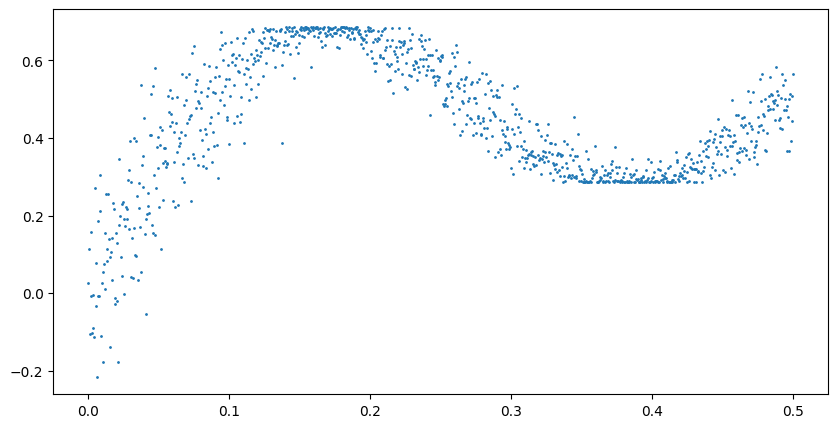

In [ ]:
x = np.linspace(0, 0.5, 1000)
ε = 0.02 * np.random.randn(x.shape[0])
y = x + 0.3 * np.sin(2 * np.pi * (x + ε)) + 0.3 * np.sin(4 * np.pi * (x + ε)) + ε

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', markersize=1);

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

file_path = '/content/NPNCaggdata_st.txt'
data = np.loadtxt(file_path)

# Separate features (X_train) and labels (Y_train)
X = data[:, :-1]  # All columns except the last one
#varying_columns = np.where(X.std(axis=0) > 0)[0]
#zp_dom zp_nc zp A_np A_dom A_nc rho_ps rho_dom rho_nc Xdomi gamma_np gamma_nc gamma_dom ...
varying_columns = [3, 4,  5,  6,  7,  8,  9, 10, 11, 18, 19, 20, 21,
       22, 24]
#for np+np collision only:
#varying_columns = [3, 4,  5,  6,  7,  8,  9, 10, 11, 14, 18, 19, 20, 21,22]
#3: zp_dom  0
#4: zp_nc   1
#5: zp      2
#6: A_np    3
#7: A_dom   4
#8: A_nc    5
#9: rho_ps  6
#10: rho_dom7
#11: rho_nc 8
#14: Xdomi  9 - exclude this
#18: g_np   10
#19: g_nc   11
#20: g_dom  12
#21: np's   13
#22: dom's  14
#24: np's   15
#25: dom's  16 - exclude this
# Select only varying columns
#X_varying = X;
X_varying = X[:, varying_columns]
y = data[:, -1]   # Last column
y = np.where(y == 0, -1, y)
#X, y = load_boston(return_X_y=True)
scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data)
X_varying = scaler.fit_transform(X_varying)
y = np.expand_dims(y, -1);#StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X_varying,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()




In [ ]:
abs(X_varying[:,2])

array([0.65628264, 2.00210017, 0.97304872, ..., 0.48477397, 0.05600272,
       0.54427733])

In [ ]:
data[0]

array([ 1.000000e-08,  2.000000e-07,  5.000000e-08,  2.307692e-02,
        1.076923e-02, -4.769231e-02,  7.017038e-20,  1.000000e-21,
        1.266380e-21,  1.566667e+03,  1.387179e+03,  2.948718e+03,
        1.000000e+01,  1.000000e+01,  9.000000e+02,  1.000000e+00,
        2.980000e+02,  1.000000e+00,  4.487179e-02,  0.000000e+00,
        4.743590e-02,  1.000000e+00,  0.000000e+00,  0.000000e+00,
        1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00])

In [ ]:
(X_train).shape
#y_train.shape

torch.Size([23141, 17])

# 2. Model

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

In [ ]:
class Model(PyroModule):

    def __init__(self, input_dim = 15, h1=15, h2=4):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_dim, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 2)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))
        self.fc4 = PyroModule[nn.Linear](2, 1)
        self.fc4.weight = PyroSample(dist.Normal(0., 1.).expand([1, 2]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, self.fc1.weight.shape[1])
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
#         mu = self.relu(self.fc3(x).squeeze())
#         sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
#         with pyro.plate("data", x.shape[0]):
#             obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
#         return mu
        mu = (torch.tanh(self.fc4(x))).squeeze()  # Remove the ReLU activation here
        #mu = self.relu(mu)  # Apply ReLU activation to ensure mu >= 0
        sigma = pyro.sample("sigma", dist.Uniform(0., 1));
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
#             binary_obs = torch.bernoulli(0.5 + 0.5 * torch.sign(mu)).long()  # 1 if > 0, -1 if <= 0
#             # Use the binary values to create observations
#             obs = binary_obs * 2 - 1  # Map 0 to -1 and 1 to 1
#             # If y is provided, use it as observations
#             if y is not None:
#                 obs = y
#             pyro.sample("obs", dist.Delta(obs), obs=y)
        return mu


# 3. Training

In [ ]:
X_train.shape

torch.Size([27744, 15])

  0%|          | 0/20000 [00:00<?, ?it/s]

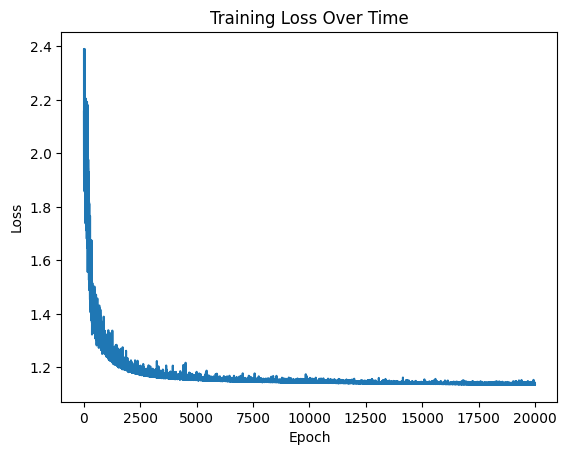

In [ ]:
import matplotlib.pyplot as plt
model = Model()
#guide = AutoDiagonalNormal(model)
guide = AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
losses = []

pyro.clear_param_store()
bar = trange(20000)
#x_train = torch.from_numpy(x).float()
#y_train = torch.from_numpy(y).float()
for epoch in bar:
    loss = svi.step(X_train, y_train.squeeze())
    losses.append(loss / X_train.shape[0])
    bar.set_postfix(loss=f'{loss / X.shape[0]:.3f}')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()
    #print(f'{loss / x.shape[0]:.3f}')

In [ ]:
names = ['zp_dom','zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc','g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np']

In [ ]:
import torch

predictive = Predictive(model, guide=guide, num_samples=500)
#x_test = torch.linspace(-0.5, 1, 3000)
preds = predictive(X_train)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

# Assuming your model, guide, and SVI are already defined and trained
# X_train and y_train are your training data and labels

# Set the model and guide to evaluation mode
model.eval()
guide.eval()

# Number of samples to draw from the posterior predictive distribution
num_samples = 1

# Initialize variables to store predictions and true labels
all_predictions = []
true_labels =[]
all_predictions_arr = []
# Use a loop to draw samples and make predictions
with torch.no_grad():
    for _ in range(num_samples):
        print(_)
        # Sample from the posterior predictive distribution
        sampled_model = guide()
        #y_pred1 = model.forward(X_train)
        preds = predictive(X_train)
        y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
        # Store predictions and true labels
        all_predictions.append(y_pred)
        true_labels.append(y_train)
        all_predictions_arr.append(preds['obs'].T.detach().numpy()>0)
# Calculate the mean prediction across all samples
mean_predictions = all_predictions; #np.mean(all_predictions, axis=0)

# Convert predictions to binary (assuming binary classification)
binary_predictions = (mean_predictions[0] > 0).astype(int)
true_labels_binary = ((true_labels[0]>0).numpy()).astype(int)
# Calculate accuracy
accuracy = np.mean(binary_predictions == true_labels_binary)
print(f'Training Accuracy: {accuracy * 100:.2f}%')


0
Training Accuracy: 52.98%


In [ ]:
true_labels_binary

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
def negative_log_likelihood(y_true, predicted_probs):
    return -np.mean(np.log(np.maximum(predicted_probs, 1e-12)))
def expected_calibration_error(y_true, predicted_probs, num_bins=10):
    confidences, accuracies = calibration_curve(y_true, predicted_probs, n_bins=num_bins)
    ece = np.sum((confidences - accuracies) * (1 / num_bins))
    return ece
def log_likelihood(y_true, predicted_probs):
    return np.mean(np.log(np.maximum(predicted_probs[np.arange(len(y_true)), y_true], 1e-12)))
def brier_score(y_true, predicted_probs):
    return np.mean(np.sum((predicted_probs - (y_true == np.arange(predicted_probs.shape[1]))[:, None])**2, axis=1))

#negative_log_likelihood(true_labels_binary, all_predictions_arr[0])
print(brier_score(true_labels_binary, all_predictions_arr[0]*1))

In [ ]:
true_labels[0]

tensor([[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]])

In [ ]:
loss / x.shape[0]

17.23496825122833

In [ ]:
import torch

# Assuming your model and guide are already defined and trained

# Save the model and guide parameters
torch.save({
    'model_state_dict': model.state_dict(),
    'guide_state_dict': guide.state_dict(),
}, '/content/sample_data/your_saved_model2.pth')


# 4. Prediction

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=500)
#x_test = torch.linspace(-0.5, 1, 3000)
preds = predictive(X_train)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

#fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(x, y, 'o', markersize=1)
#ax.plot(x_test, y_pred)
#ax.fill_between(x_test, y_pred - y_std, y_pred + y_std,
#                alpha=0.5, color='#ffcd3c');

In [ ]:
preds['obs'].T.detach().numpy()

In [ ]:
#3: zp_dom  0
#4: zp_nc   1
#5: zp      2
#6: A_np    3
#7: A_dom   4
#8: A_nc    5
#9: rho_ps  6
#10: rho_dom7
#11: rho_nc 8
#18: g_np   9
#19: g_nc   10
#20: g_dom  11
#21: np's   12
#22: dom's  13
#24: np's   14


In [ ]:
np.unique(X_train[:,13])

array([-1.3562449 , -1.1775208 , -0.9987965 , -0.8200723 , -0.64134806,
       -0.46262383, -0.2838996 , -0.10517538,  0.07354885,  0.25227308,
        0.43099728,  0.60972154,  0.7884458 ,  0.96717   ,  1.1458942 ,
        1.3246185 ,  1.5033426 ,  1.6820669 ,  1.8607911 ,  2.0395153 ,
        2.2182395 ], dtype=float32)

In [ ]:
X_play = torch.tensor([-1.085, -1.085, -1.01, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0.09,  -2, 0.09]);
X_play = torch.tensor([-1.085, -1.085, +1.01,
                       0, 0, 0,
                       0, 0, 0,
                       0, 0, 0,
                       -0.3828,  -0.9487,  -0.7722]);
X_play = torch.tensor(np.median(X_train,0));   X_play[13] = 1.5033426; X_play[0] = -1.4209836;  X_play[1] = -1.4304974; X_play[2] = 1.423745;
X_play[14] = -1.0340632;
scaler.inverse_transform(X_play.reshape(1, -1))
paramv0 = scaler.inverse_transform(X_play.reshape(1, -1))
print(names)
print(paramv0)

['zp_dom', 'zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc', 'g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np']
[[-5.07692319e-02 -5.07692304e-02  5.07692293e-02  1.06081803e-20
   9.42668481e-21  1.06081797e-20  1.92564100e+03  1.41282100e+03
   2.48717900e+03  2.56410300e-02  2.56410300e-02  2.43589700e-02
   9.99999997e-01  1.59999999e+01  7.40985429e-08]]


In [ ]:
from statsmodels.stats.proportion import proportion_confint
pred_mat = np.zeros([17,10]);
pred_mat2 = np.zeros([17,10]);
pred_mat2_std = np.zeros([17,10]);
pred_mat2_low = np.zeros([17,10]);
pred_mat2_high = np.zeros([17,10]);
parameter_val = np.zeros([17,10]);
#X_play = torch.tensor([-1.085, -1.085, 1.01, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);
#X_play = torch.tensor([-1.085, -1.085, +1.01, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0,  -1,  0]);
#X_play = torch.tensor([-1.085, -1.085, 0.1, 0, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0.0,  -0.663]);
arrayv = np.linspace(-2,2,10)
for j in range(15):
  print(j);
  for i in range(10):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     preds1 = predictive(X_play2)
     y_pred1 = (preds1['obs']>0).detach().numpy()*1;
     #pred_mat[j,i] = y_pred1;
     pred_mat2[j,i] = np.mean(y_pred1);#(sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
     ci_low, ci_upp = proportion_confint(sum(y_pred1), len(y_pred1), alpha=0.01, method='wilson')
     pred_mat2_low[j,i] = ci_low;
     pred_mat2_high[j,i] = ci_upp;
     #pred_mat2_std[j,i] = np.std((preds1['obs']>0).detach().numpy())
     parameter_val[j,i] = paramv[0][j];


import os
import shutil

output_folder = f"/content/sample_data/npnc_agg_st_DOM={X_play[13]}"
if not os.path.exists(output_folder):
        os.makedirs(output_folder)
np.savetxt(f'{output_folder}/pred_mat3_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2)
np.savetxt(f'{output_folder}/pred_mat3_low_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_low)
np.savetxt(f'{output_folder}/pred_mat3_high_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_high)
np.savetxt(f'{output_folder}/parameter_val_npnc_agg_st_DOM={X_play[13]}.txt', parameter_val)
shutil.make_archive(output_folder, 'zip', output_folder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


'/content/sample_data/npnc_agg_st_DOM=-1.3562449216842651.zip'

In [ ]:
import os
import shutil
output_folder = f"/content/sample_data/npnc_agg_st_DOM={X_play[13]}"
if not os.path.exists(output_folder):
        os.makedirs(output_folder)
np.savetxt(f'{output_folder}/pred_mat3_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2)
np.savetxt(f'{output_folder}/pred_mat3_low_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_low)
np.savetxt(f'{output_folder}/pred_mat3_high_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_high)
np.savetxt(f'{output_folder}/parameter_val_npnc_agg_st_DOM={X_play[13]}.txt', parameter_val)
shutil.make_archive(output_folder, 'zip', output_folder)

'/content/sample_data/npnc_agg_st_DOM=-1.177520751953125.zip'

In [ ]:
import zipfile

filename ="npnc_agg_st_DOM=-1.177520751953125.zip";
new_folder=f"/content/sample_data/{filename[:-4]}"
os.mkdir(new_folder)
with zipfile.ZipFile(f"/content/sample_data/{filename}", 'r') as zip_ref:
    zip_ref.extractall(new_folder)

[0.25386487 0.25950307 0.38592186 0.468517   0.57505533 0.63659366
 0.69706493 0.72878607 0.76086299 0.75227125]
[0.31642519 0.31451268 0.26138476 0.28215676 0.22769384 0.18159161
 0.08233581 0.04589475 0.08403959 0.0721878 ]
[0.06383888 0.0789386  0.07050971 0.08233581 0.09260725 0.14539416
 0.15979128 0.24449109 0.37425392 0.39567051]
[0.34715965 0.33752831 0.29544341 0.29164195 0.29734571 0.32216874
 0.32600273 0.28784469 0.3068727  0.31260117]
[0.35681493 0.36843249 0.33368254 0.29734571 0.33368254 0.29544341
 0.2764785  0.33176112 0.29164195 0.28594765]
[0.35294997 0.32792121 0.32408524 0.33368254 0.28026293 0.27269843
 0.32408524 0.25574312 0.3068727  0.28974279]
[0.5204509  0.50040272 0.43095451 0.3917683  0.35681493 0.26703658
 0.22955528 0.20730305 0.19624939 0.18707717]
[0.36455621 0.35101891 0.34715965 0.35101891 0.30878118 0.35488198
 0.32600273 0.33752831 0.31069067 0.26326757]
[0.32408524 0.3068727  0.31642519 0.31260117 0.32025322 0.33368254
 0.33752831 0.31642519 0.3317

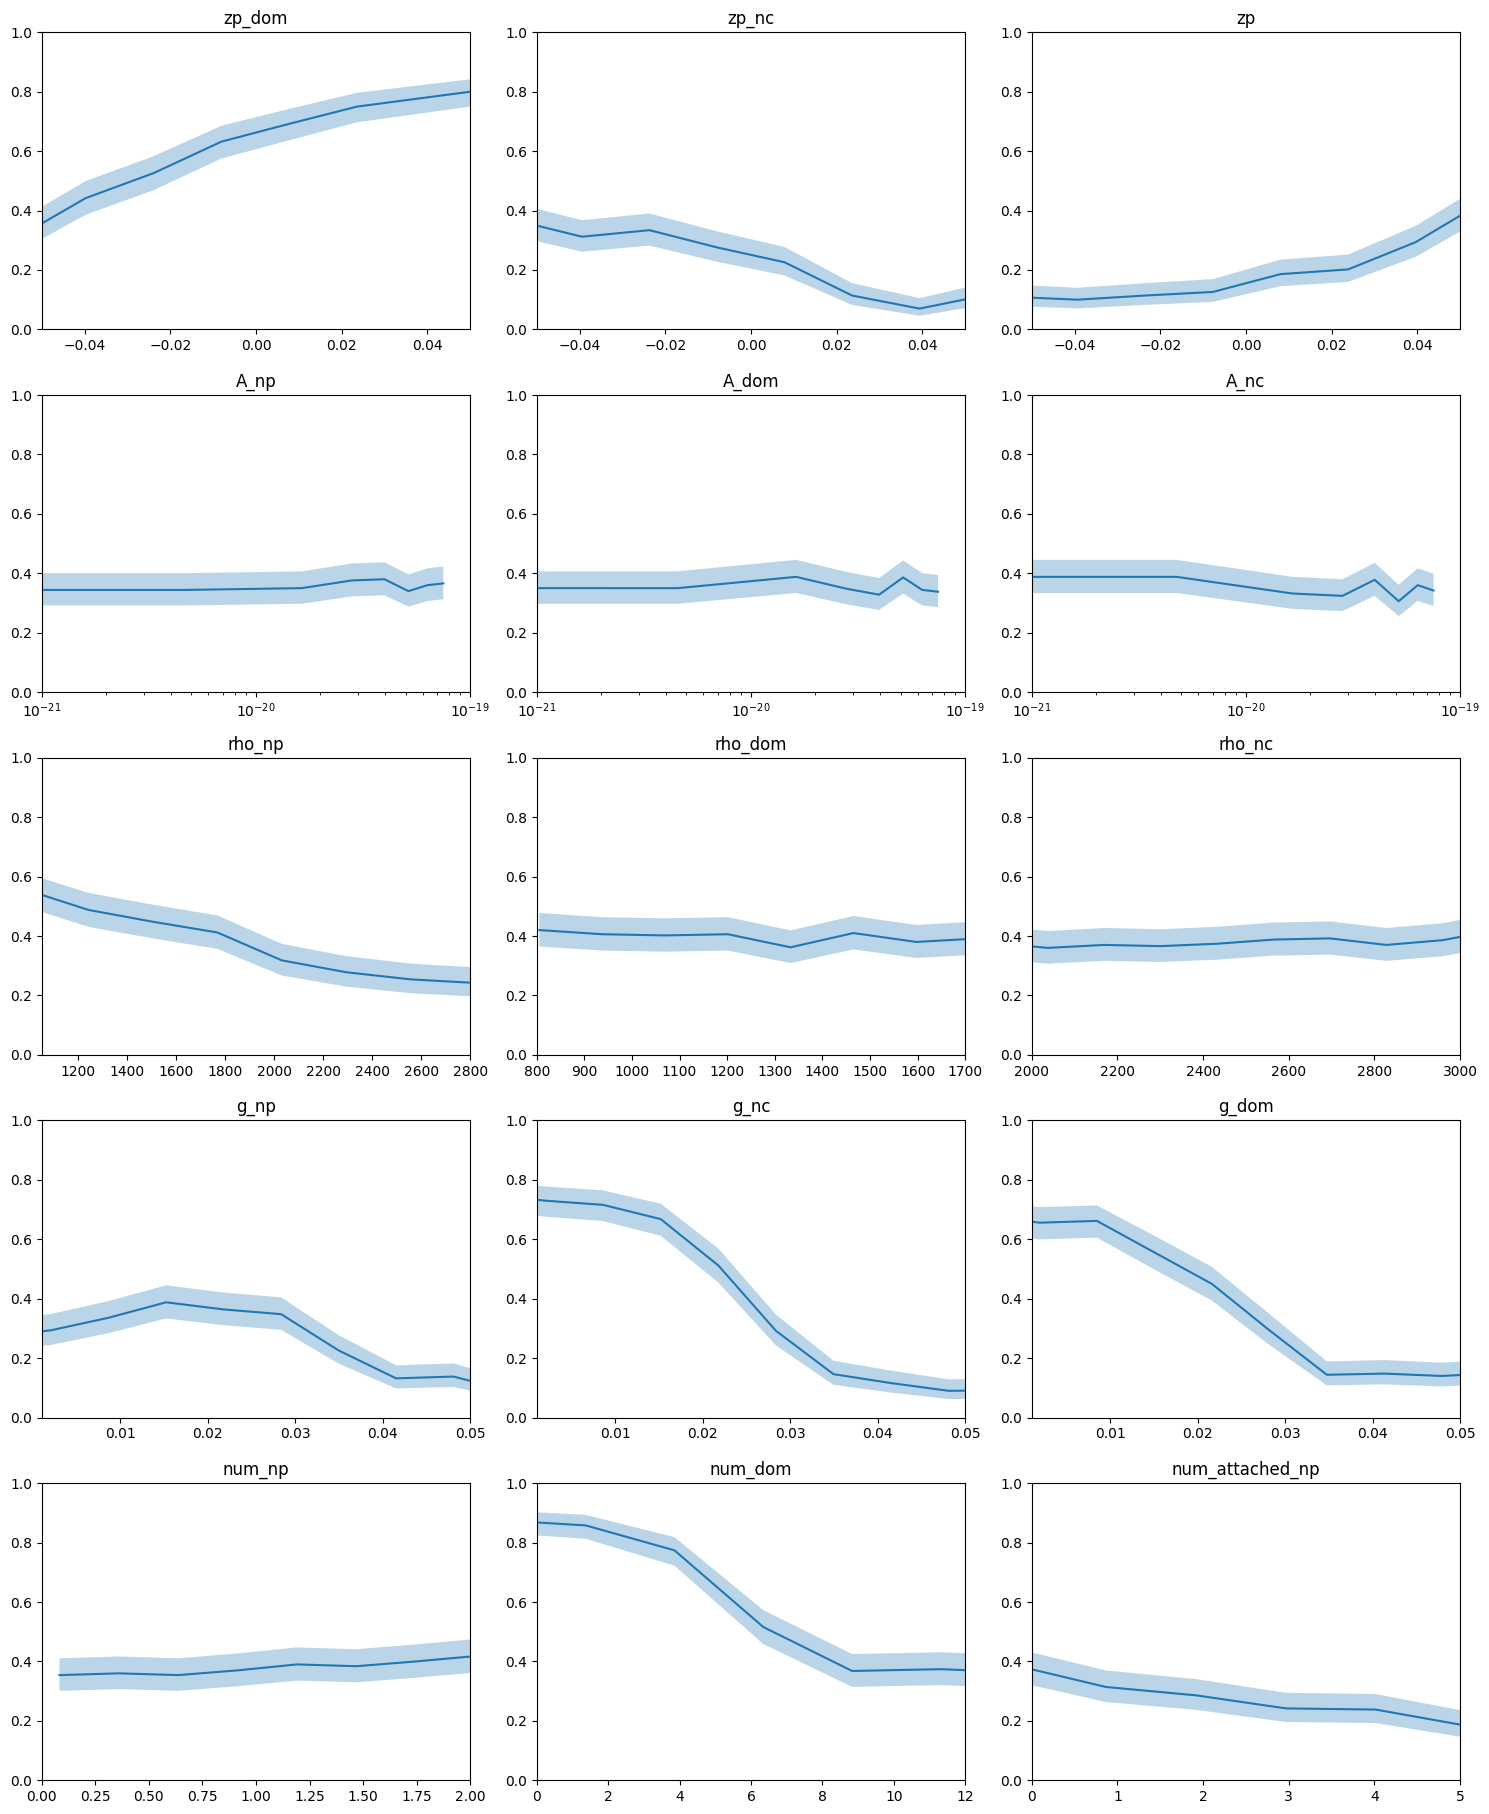

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
lower_lims = [-0.05,-0.05, -0.05, 1e-21, 1e-21, 1e-21, 1050, 800, 2000, 0.001,0.001,0.001,0,0,0]
upper_lims = [0.05,0.05, 0.05, 1e-19, 1e-19, 1e-19, 2800, 1700, 3000, 0.05,0.05,0.05,2,12,5]
names = ['zp_dom','zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc','g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np']
def plot_subplots_with_fill(data, conf_low, conf_high, names, values, lower_lims, upper_lims):
    num_subplots = len(data)

    # Check if the input contains exactly 17 arrays, each with 10 elements
    #if num_subplots != 17 or any(len(subarray) != 10 for subarray in data):
    #    raise ValueError("Input must be an array containing 17 arrays, each with 10 elements.")

    # Create a 4x5 grid for subplots
    fig, axes = plt.subplots(5, 3, figsize=(15, 19))
    #fig.suptitle('17 Subplots with 10 Elements Each and 25-75% Percentile Fill')

    # Flatten the 2D array of subplot axes to easily iterate over them
    axes = axes.flatten()

    for i, (subplot_data, subplot_low, subplot_high, name, value) in enumerate(zip(data, conf_low, conf_high, names, values)):
        # Plot the data on the current subplot
        axes[i].plot(value, subplot_data, label='Data')

        # Plot the 25-75% percentile fill area
        lower_bound = subplot_low
        print(lower_bound)
        #print(lower_bound)
        upper_bound = subplot_high
        axes[i].set_title(name)
        axes[i].fill_between(value, lower_bound, upper_bound, alpha=0.3, label='25-75% Percentile')
        axes[i].set_ylim(0.0, 1)
        axes[i].set_xlim(lower_lims[i], upper_lims[i])

        if i==3 or i==4 or i==5:
            axes[i].set_xscale('log')
        #axes[i].set_title(f'Subplot {i + 1}')
        #axes[i].legend()

    # Adjust layout to prevent overlapping titles
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()

# Example usage:
# Replace 'your_input_data' and 'your_input_std' with
plot_subplots_with_fill(pred_mat2, pred_mat2_low, pred_mat2_high, names, parameter_val, lower_lims, upper_lims)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
(60, 40)
(60, 40)
(60, 40)


<ipython-input-48-3b4efd0ec306>:75: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-48-3b4efd0ec306>:76: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-48-3b4efd0ec306>:77: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


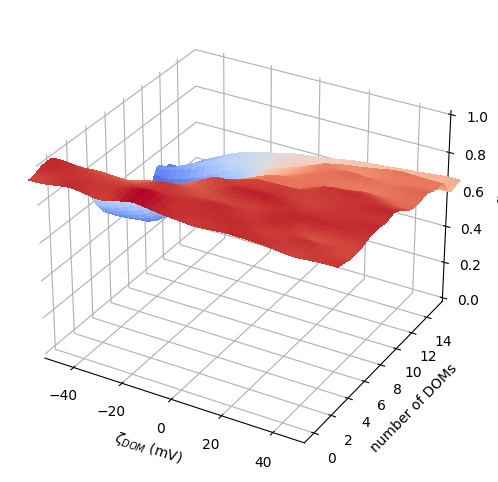

(60, 40)
(60, 40)
(60, 40)


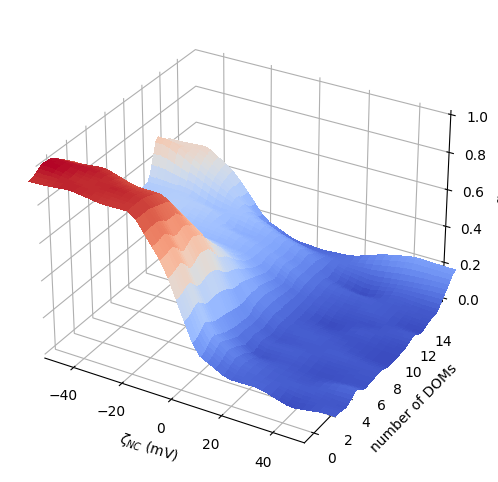

(60, 40)
(60, 40)
(60, 40)


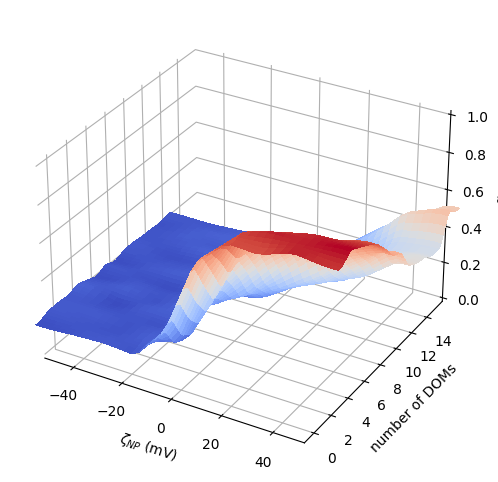

(60, 40)
(60, 40)
(60, 40)


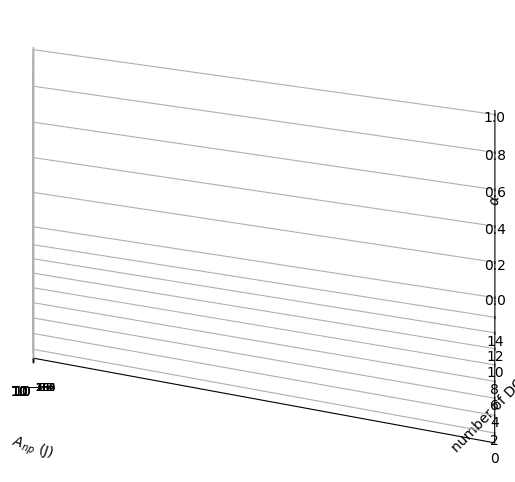

(60, 40)
(60, 40)
(60, 40)


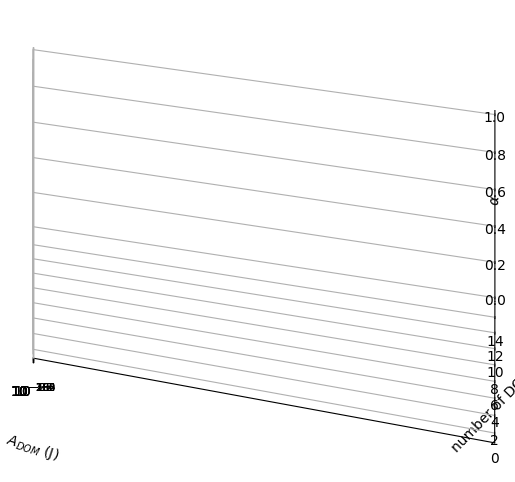

(60, 40)
(60, 40)
(60, 40)


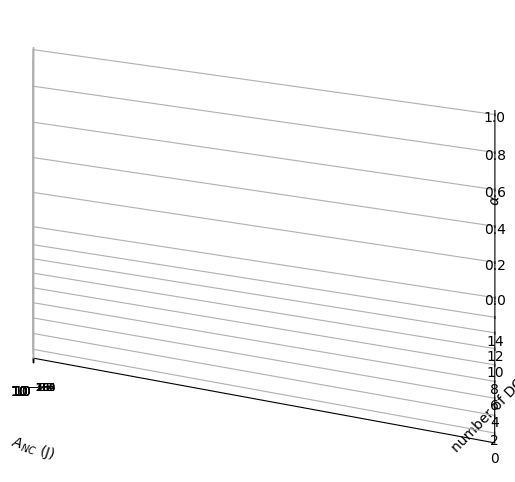

(60, 40)
(60, 40)
(60, 40)


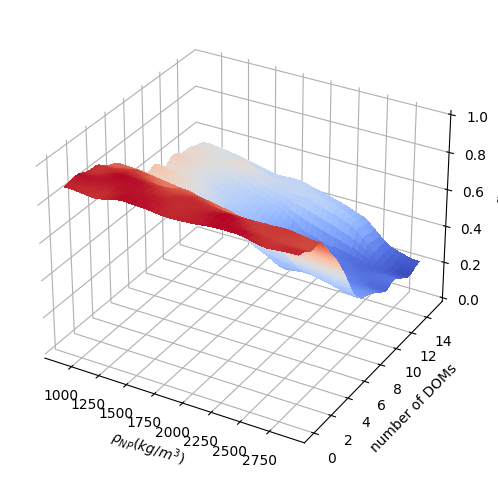

(60, 40)
(60, 40)
(60, 40)


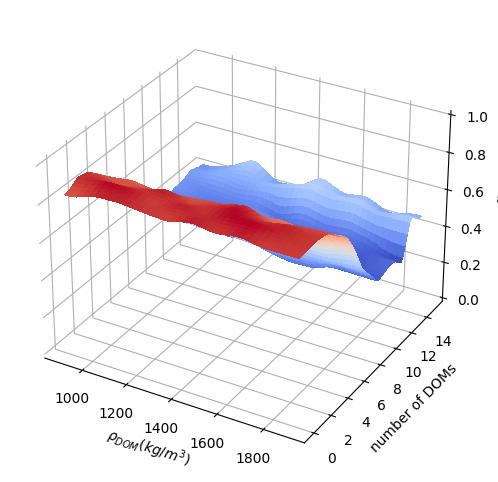

(60, 40)
(60, 40)
(60, 40)


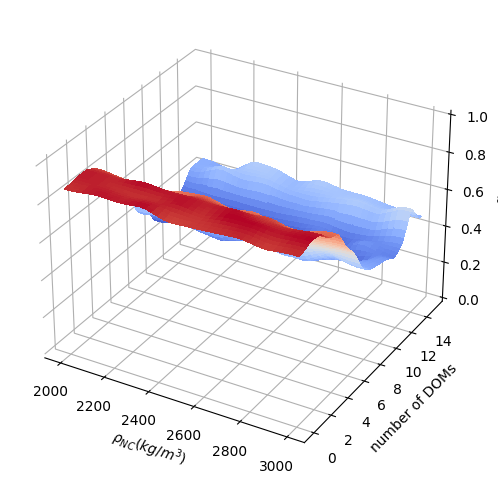

(60, 40)
(60, 40)
(60, 40)


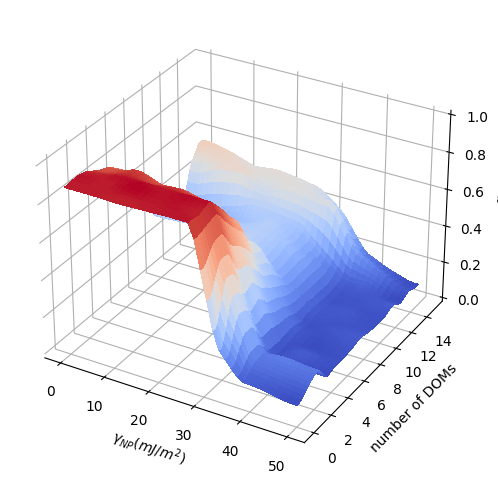

(60, 40)
(60, 40)
(60, 40)


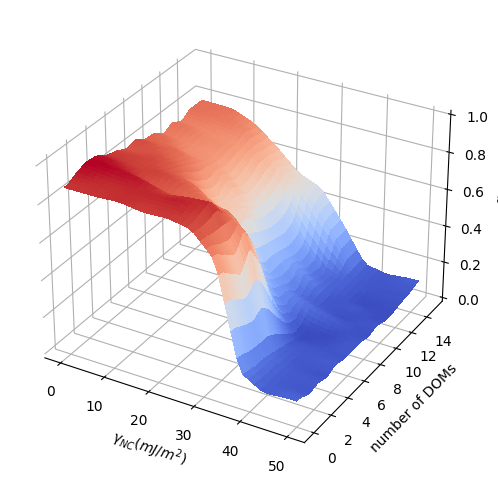

(60, 40)
(60, 40)
(60, 40)


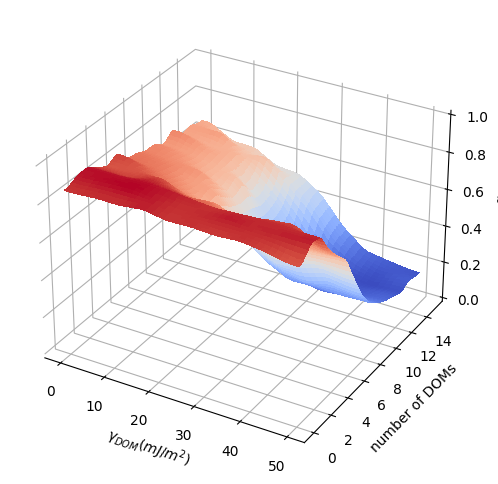

(60, 40)
(60, 40)
(60, 40)


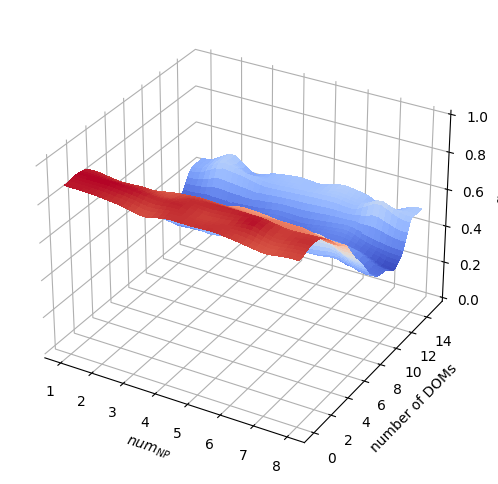

(60, 40)
(60, 40)
(60, 40)


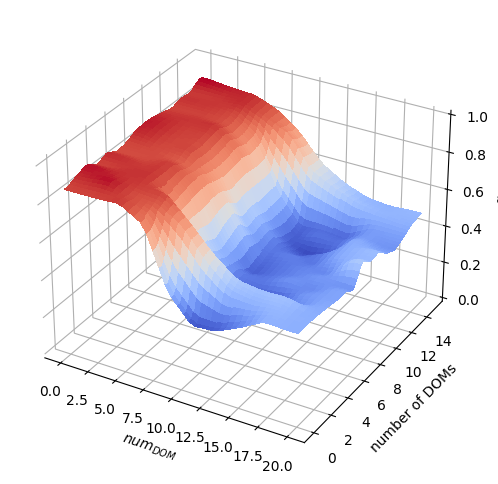

(60, 40)
(60, 40)
(60, 40)


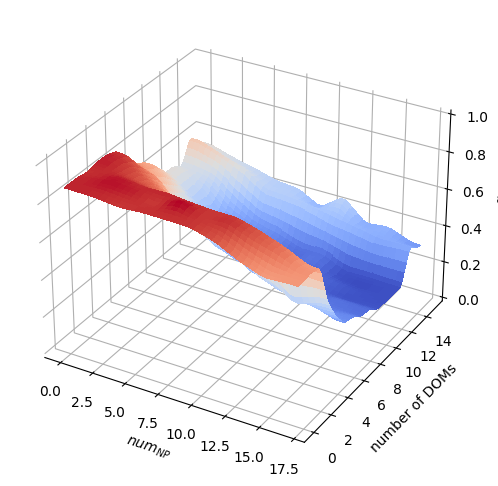

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import shutil
import zipfile
import cv2

parameter_val = np.zeros([15,40])
array_dom = np.linspace(-6.6289e-01,5.1692,10)
for j in range(15):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),40);
  for i in range(40):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     #for k in range(10):
     #X_play2[9] = array_dom[k];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     parameter_val[j,i] = paramv[0][j];

DOM_list = np.loadtxt('/content/DOM_list2.txt')
DOM_list

pred_mat3 = np.zeros([17,len(DOM_list),10]);
pred_mat3_std = np.zeros([17,len(DOM_list),10]);
pred_mat3_low = np.zeros([17,len(DOM_list),10]);
pred_mat3_high = np.zeros([17,len(DOM_list),10]);
#parameter_val = np.zeros([17,10]);
for kj in range(len(DOM_list)):
  p1 = np.loadtxt(f'/content/sample_data/npnc_agg_st_DOM={DOM_list[kj]}/pred_mat3_npnc_agg_st_DOM={DOM_list[kj]}.txt');
  p1_low = np.loadtxt(f'/content/sample_data/npnc_agg_st_DOM={DOM_list[kj]}/pred_mat3_low_npnc_agg_st_DOM={DOM_list[kj]}.txt');
  p1_high = np.loadtxt(f'/content/sample_data/npnc_agg_st_DOM={DOM_list[kj]}/pred_mat3_high_npnc_agg_st_DOM={DOM_list[kj]}.txt');

  for i in range(17):
    for j in range(10):
     # for k in range(len(DOM_list)):
      pred_mat3[i,kj,j] = p1[i,j];
      pred_mat3_low[i,kj,j] = p1_low[i,j];
      pred_mat3_high[i,kj,j] = p1_high[i,j];


parameter_val[0,:] = parameter_val[0,:]*1000;
parameter_val[1,:] = parameter_val[1,:]*1000;
parameter_val[2,:] = parameter_val[2,:]*1000;
parameter_val[3,:] = np.exp(parameter_val[3,:]);
parameter_val[4,:] = np.exp(parameter_val[4,:]);
parameter_val[5,:] = np.exp(parameter_val[5,:]);
parameter_val[9,:] = parameter_val[9,:]*1000;
parameter_val[10,:] = parameter_val[10,:]*1000;
parameter_val[11,:] = parameter_val[11,:]*1000;

def plot_3d_subplots(data, data_low, data_high, names, names_raw, parameter_val,  lower_lims, upper_lims):
 output_folder = "/content/NPNCagg_st"
 if not os.path.exists(output_folder):
        os.makedirs(output_folder)

 for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a new figure for each subplot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        value2 = np.linspace(value[0],value[-1],40);
        # Create a meshgrid for the 10x10 array
        y, x = np.meshgrid(np.transpose(value), np.linspace(0,15,60));

        arr =  cv2.resize(array, (40, 60), interpolation=cv2.INTER_LINEAR)
        print(arr.shape)
        print(x.shape)
        print(y.shape)
        # Plot the 3D surface
        ax.plot_surface(y,x,(arr), cmap=cm.coolwarm, edgecolor='none',  antialiased=False, rcount=10000, ccount=10000)
        ax.set_zlim(0, 1)

        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_xlabel(name)
        ax.set_ylabel('number of DOMs')
        ax.set_zlabel(r'$\alpha$')
        #ax.set_xlim(value[0], value[39])
        #ax.set_xlim(lower_lims[i], upper_lims[i])
        if i==3 or i==4 or i==5:
            ax.set_xscale('log')
        if i==0 or i==1 or i==2:
            ax.set_xlim(-50, 50)
        # Save each individual figure with extended bbox
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #pad_inches_x = -0.3  # Adjust the padding to the right
        #pad_inches_y = -0.6  # Adjust the padding down
        #extent.x0 += pad_inches_x
        #extent.y0 += -0.5
        #extent.x1 += 0.52
        #extent.y1 += 0
        file_path = os.path.join(output_folder, f'NPNCagg_{names_raw[i]}_st.png')
        fig.savefig(file_path)
        #fig.savefig(f'NPNPagg_{names_raw[i]}.png')

        # Close the figure to release resources
        plt.show()
        plt.close(fig)
 shutil.make_archive(output_folder, 'zip', output_folder)
    # Show the plot (optional)


# Example usage:
# Replace the following with your actual data


# Call the function
lower_lims = [-50,-50, 5e-21, 5e-21, 1050, 800, 0, 0,1,0]
upper_lims = [50,50, 8e-20, 8e-20, 1700, 2000, 50, 50,1,12]
#names = ['zp_dom', 'zp', 'A_np', 'A_dom', 'rho_np', 'rho_dom','g_np', 'g_dom', 'num_np', 'num_dom']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NC}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$A_{NC}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\rho_{NC} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{NC} (mJ/m^{2})$',r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$', r'$num_{NP}$']
names_raw = [r'zeta_DOM', r'zeta_NC', r'zeta_NP', r'A_NP', r'A_DOM',  r'A_NC',r'rho_NP', r'rho_DOM', r'rho_NC',r'gamma_NP', r'gamma_NC', r'gamma_DOM', r'num_NP', r'num_DOM', r'num_NP']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, names_raw,parameter_val, lower_lims, upper_lims)


## 3d

In [ ]:
pred_mat = np.zeros([17,10]);
pred_mat3 = np.zeros([17,10,10]);
pred_mat3_std = np.zeros([17,10,10]);
pred_mat3_low = np.zeros([17,10,10]);
pred_mat3_high = np.zeros([17,10,10]);
parameter_val = np.zeros([17,10]);
X_play = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);
X_play = torch.tensor([-1.085,-1.085, +1.01,
                       0, 0, 0,
                       0, 0, 0,
                        0, 0, 0,
                       -0.2102, 0, -6.6289e-01]);
scaler.inverse_transform(X_play.reshape(1, -1))

arrayv = np.linspace(-2.2,2.2,10)
for j in range(10):
  print(j);
  for i in range(10):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     for k in range(10):
        X_play2[13] = arrayv[k];
        paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
        parameter_val[j,i] = paramv[0][j];
        parameter_val[i]
        preds1 = predictive(X_play2)
         #y_pred1 = preds1['obs'].T.detach().numpy().mean(axis=1)
         #pred_mat[j,i] = y_pred1;
        pred_mat3[j,i,k] = (sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
        #pred_mat3_std[j,i,k] = np.std((preds1['obs']>0).detach().numpy())
        y_pred1 = (preds1['obs']>0).detach().numpy()*1;
        ci_low, ci_upp = proportion_confint(sum(y_pred1), len(y_pred1), alpha=0.01, method='wilson')
        pred_mat3_low[j,i,k] = ci_low;
        pred_mat3_high[j,i,k] = ci_upp;

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_subplots(data, data_low, data_high, names, parameter_val):
    num_subplots = len(data)

    # Check if the input contains exactly 17 arrays, each with dimensions 10x10
    #if num_subplots != 17 or any(subarray.shape != (20, 20) for subarray in data):
    #    raise ValueError("Input must be an array containing 17 arrays, each with dimensions 10x10.")

    # Create a 4x5 grid for subplots
    fig = plt.figure(figsize=(15, 12))
    #fig.suptitle('1 Subplots with 3D Surface Plot of 10x10 Arrays')

    for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a 3D subplot
        ax = fig.add_subplot(4, 5, i + 1, projection='3d')

        # Create a meshgrid for the 10x10 array
        x, y = np.meshgrid(np.arange(10), value)

        #array_25=array[0:10]-array_std[0:10]*0.67
        #array_75=array[0:10]+array_std[0:10]*0.67
        # Plot the 3D surface
        ax.plot_surface(x, y, array, cmap='viridis', edgecolor='k')
        #surf2 = ax.plot_surface(x, y, array_low, cmap='gray', edgecolor='none', alpha=0.5, linewidth=0)
        #surf3 = ax.plot_surface(x, y, array_high, cmap='gray', edgecolor='none', alpha=0.5, linewidth=0)
        ax.set_title(name)  # Set the title to the corresponding name
        ax.set_zlim(0, 1)

        ax.set_ylabel(name)
        ax.set_xlabel('number of DOMs')
        ax.set_zlabel('alpha')
    # Adjust layout to prevent overlapping titles
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()

# Example usage:
# Replace 'your_3d_data' and 'your_names' with the actual 3D array and array of names
# 'your_3d_data' is the 3D array with dimensions 17x10x10, and 'your_names' is the array of names
your_3d_data = np.random.rand(17, 10, 10)
#your_names = ['Name1', 'Name2', 'Name3', 'Name4', 'Name5', 'Name6', 'Name7', 'Name8', 'Name9', 'Name10',
#              'Name11', 'Name12', 'Name13', 'Name14', 'Name15', 'Name16', 'Name17']
lower_lims = [-0.05,-0.05, -0.05, 1e-21, 1e-21, 1e-21, 1050, 800, 2000, 0.001,0.001,0.001,0,0,0]
upper_lims = [0.05,0.05, 0.05, 1e-19, 1e-19, 1e-19, 2800, 1700, 3000, 0.05,0.05,0.05,2,12,5]
names = ['zp_dom','zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc','g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, parameter_val)


## np agg model

In [ ]:
class Model(PyroModule):

    def __init__(self, input_dim = 10, h1=10, h2=4):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_dim, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 2)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))
        self.fc4 = PyroModule[nn.Linear](2, 1)
        self.fc4.weight = PyroSample(dist.Normal(0., 1.).expand([1, 2]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, self.fc1.weight.shape[1])
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
#         mu = self.relu(self.fc3(x).squeeze())
#         sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
#         with pyro.plate("data", x.shape[0]):
#             obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
#         return mu
        mu = (torch.tanh(self.fc4(x))).squeeze()  # Remove the ReLU activation here
        #mu = self.relu(mu)  # Apply ReLU activation to ensure mu >= 0
        sigma = pyro.sample("sigma", dist.Uniform(0., 1));
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
#             binary_obs = torch.bernoulli(0.5 + 0.5 * torch.sign(mu)).long()  # 1 if > 0, -1 if <= 0
#             # Use the binary values to create observations
#             obs = binary_obs * 2 - 1  # Map 0 to -1 and 1 to 1
#             # If y is provided, use it as observations
#             if y is not None:
#                 obs = y
#             pyro.sample("obs", dist.Delta(obs), obs=y)
        return mu


  0%|          | 0/5000 [00:00<?, ?it/s]

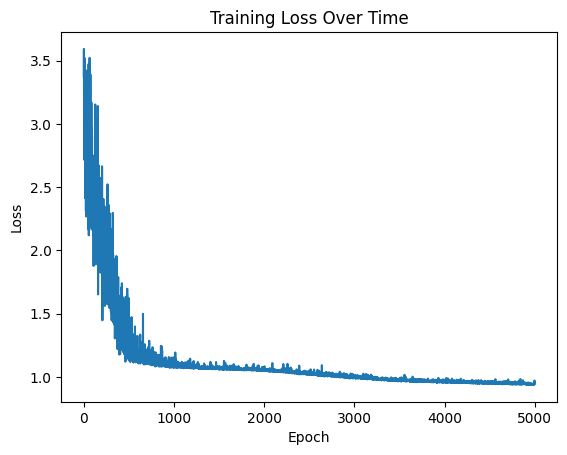

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

file_path = '/content/NPaggdata_st.txt'
data = np.loadtxt(file_path)

# Separate features (X_train) and labels (Y_train)
X = data[:, :-1]  # All columns except the last one
#varying_columns = np.where(X.std(axis=0) > 0)[0]
#zp_dom zp_nc zp A_np A_dom A_nc rho_ps rho_dom rho_nc Xdomi gamma_np gamma_nc gamma_dom ...

varying_columns = [3,  5,  6,  7,  9, 10, 18, 20, 21,
       22]

#for np+np collision only:
#varying_columns = [3, 4,  5,  6,  7,  8,  9, 10, 11, 14, 18, 19, 20, 21,22]
#3: zp_dom  0
#5: zp      1
#6: A_np    2
#7: A_dom   3
#9: rho_ps  4
#10: rho_dom5
#18: g_np   6
#20: g_dom  7
#21: np's   8
#22: dom's  9

# Select only varying columns
#X_varying = X;
X_varying = X[:, varying_columns]
X_varying[:,2] = np.log(X_varying[:,2]); X_varying[:,3] = np.log(X_varying[:,3]);# X_varying[:,5] = np.log(X_varying[:,5]);
y = data[:, -1]   # Last column
y = np.where(y == 0, -1, y)
#X, y = load_boston(return_X_y=True)
scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data)
X_varying = scaler.fit_transform(X_varying)
#X_varying[:,1] = 0;
#X_varying[:,5] = 0;
#X_varying[:,10] = 0;

y = np.expand_dims(y, -1);#StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X_varying,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()


import matplotlib.pyplot as plt
model_np = Model()
#guide = AutoDiagonalNormal(model)
guide = AutoMultivariateNormal(model_np)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model_np, guide, adam, loss=Trace_ELBO())
losses = []

pyro.clear_param_store()
bar = trange(5000)
#x_train = torch.from_numpy(x).float()
#y_train = torch.from_numpy(y).float()
for epoch in bar:
    loss = svi.step(X_train, y_train.squeeze())
    losses.append(loss / X_train.shape[0])
    bar.set_postfix(loss=f'{loss / X.shape[0]:.3f}')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()
    #print(f'{loss / x.shape[0]:.3f}')

torch.Size([64001, 10])

In [ ]:
X_varying

array([[ 1.33674982,  0.        ,  1.00727728, ..., -0.21016148,
        -0.66289256, -0.21016148],
       [ 1.33674982,  0.        ,  1.00727728, ..., -0.21016148,
        -0.42960694, -0.21016148],
       [ 1.33674982,  0.        ,  1.00727728, ..., -0.21016148,
        -0.42960694, -0.21016148],
       ...,
       [-1.04144568,  0.        ,  0.03156925, ..., -0.21016148,
         1.43667802, -0.21016148],
       [ 0.74220107,  0.        , -1.29539367, ..., -0.21016148,
         1.43667802, -0.21016148],
       [ 0.96515667,  0.        , -1.2173371 , ..., -0.21016148,
         1.43667802, -0.21016148]])

In [ ]:
import torch
model_np=model;
predictive = Predictive(model_np, guide=guide, num_samples=500)
#x_test = torch.linspace(-0.5, 1, 3000)
preds = predictive(X_train)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

# Assuming your model, guide, and SVI are already defined and trained
# X_train and y_train are your training data and labels

# Set the model and guide to evaluation mode
model_np.eval()
guide.eval()

# Number of samples to draw from the posterior predictive distribution
num_samples = 1

# Initialize variables to store predictions and true labels
all_predictions = []
true_labels =[]

# Use a loop to draw samples and make predictions
with torch.no_grad():
    for _ in range(num_samples):
        print(_)
        # Sample from the posterior predictive distribution
        sampled_model = guide()
        #y_pred1 = model.forward(X_train)
        preds = predictive(X_train)
        y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
        # Store predictions and true labels
        all_predictions.append(y_pred)
        true_labels.append(y_train)

# Calculate the mean prediction across all samples
mean_predictions = all_predictions; #np.mean(all_predictions, axis=0)

# Convert predictions to binary (assuming binary classification)
binary_predictions = (mean_predictions[0] > 0).astype(int)
true_labels_binary = ((true_labels[0]>0).numpy()).astype(int)
# Calculate accuracy
accuracy = np.mean(binary_predictions == true_labels_binary)
print(f'Training Accuracy: {accuracy * 100:.2f}%')

all_predictions = []
true_labels =[]
# Use a loop to draw samples and make predictions
with torch.no_grad():
    for _ in range(num_samples):
        print(_)
        # Sample from the posterior predictive distribution
        sampled_model = guide()
        #y_pred1 = model.forward(X_train)
        preds1 = predictive(X_test)
        y_pred1 = preds1['obs'].T.detach().numpy().mean(axis=1)
        # Store predictions and true labels
        all_predictions.append(y_pred1)
        true_labels.append(y_test)

# Calculate the mean prediction across all samples
mean_predictions = all_predictions; #np.mean(all_predictions, axis=0)

# Convert predictions to binary (assuming binary classification)
binary_predictions = (mean_predictions[0] > 0).astype(int)
true_labels_binary = ((true_labels[0]>0).numpy()).astype(int)
# Calculate accuracy
accuracy = np.mean(binary_predictions == true_labels_binary)
print(f'Testing Accuracy: {accuracy * 100:.2f}%')


0
Training Accuracy: 77.56%
0
Testing Accuracy: 78.05%


In [ ]:
np.unique(X_train[:,9])


array([-0.88845086, -0.6884684 , -0.48848593, -0.28850344, -0.08852098,
        0.11146149,  0.31144395,  0.51142645,  0.7114089 ,  0.9113914 ,
        1.1113739 ,  1.3113563 ,  1.5113388 ,  1.7113212 ,  1.9113038 ,
        2.1112862 ,  2.3112686 ,  2.5112512 ,  2.7112336 ,  2.911216  ,
        3.1111987 ], dtype=float32)

In [ ]:
np.median(X_train[:],0)

array([-0.17061551, -0.33041632,  0.19353753,  0.29155406, -0.11467927,
       -0.0667197 , -0.03537395,  0.04310432, -0.25624675, -0.48848593],
      dtype=float32)

In [ ]:
X_play = torch.tensor([-0.3304, -0.0749,
                       0, 0,
                       0, 0,
                        0, 0,
                       -0.2562,  0.5114]);
X_play = torch.tensor(np.median(X_train[:],0));   X_play[9] =2.5112512; X_play[1] = 1.8;  X_play[0] = -0.79;
scaler.inverse_transform(X_play.reshape(1, -1))

array([[-3.88722168e-02,  4.04408140e-02, -4.56384174e+01,
        -4.54098480e+01,  1.72051300e+03,  1.38717900e+03,
         2.55000000e-02,  2.55000000e-02,  1.00000000e+00,
         1.70000004e+01]])

In [ ]:
from statsmodels.stats.proportion import proportion_confint
pred_mat = np.zeros([17,10]);
pred_mat2 = np.zeros([17,10]);
pred_mat2_std = np.zeros([17,10]);
pred_mat2_low = np.zeros([17,10]);
pred_mat2_high = np.zeros([17,10]);
parameter_val = np.zeros([17,10]);
#X_play = torch.tensor([-1.085, -1.085, 1.01, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);
#X_play = torch.tensor([-1.085, -1.085, +1.01, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0,  -1,  0]);
#X_play = torch.tensor([-1.085, -1.085, 0.1, 0, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0.0,  -0.663]);
arrayv = np.linspace(-2.2,2.2,10)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),10);
  for i in range(10):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     preds1 = predictive(X_play2)
     y_pred1 = (preds1['obs']>0).detach().numpy()*1;
     #pred_mat[j,i] = y_pred1;
     pred_mat2[j,i] = np.mean(y_pred1);#(sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
     ci_low, ci_upp = proportion_confint(sum(y_pred1), len(y_pred1), alpha=0.01, method='wilson')
     pred_mat2_low[j,i] = ci_low;
     pred_mat2_high[j,i] = ci_upp;
     #pred_mat2_std[j,i] = np.std((preds1['obs']>0).detach().numpy())
     if j == 2 or j ==3:
         parameter_val[j,i] = np.exp(paramv[0][j]);
     elif j== 8 or j==9 or j==4 or j==5:
         parameter_val[j,i] = paramv[0][j];
     else:
         parameter_val[j,i] = paramv[0][j]*1000;

import os
import shutil

output_folder = f"/content/sample_data/npnp_agg_st_DOM={X_play[9]}"
if not os.path.exists(output_folder):
        os.makedirs(output_folder)
np.savetxt(f'{output_folder}/pred_mat3_npnp_agg_st_DOM={X_play[9]}.txt', pred_mat2)
np.savetxt(f'{output_folder}/pred_mat3_low_npnp_agg_st_DOM={X_play[9]}.txt', pred_mat2_low)
np.savetxt(f'{output_folder}/pred_mat3_high_npnp_agg_st_DOM={X_play[9]}.txt', pred_mat2_high)
np.savetxt(f'{output_folder}/parameter_val_npnp_agg_st_DOM={X_play[9]}.txt', parameter_val)
shutil.make_archive(output_folder, 'zip', output_folder)

0
1
2
3
4
5
6
7
8
9


'/content/sample_data/npnp_agg_st_DOM=2.511251211166382.zip'

'/content/sample_data/npnp_agg_st_DOM=-0.6884683966636658.zip'

[0.266 0.26  0.3   0.486 0.51  0.252 0.124 0.06  0.046 0.052]
[0.038 0.042 0.104 0.192 0.22  0.25  0.276 0.298 0.296 0.34 ]
[0.226 0.23  0.24  0.26  0.272 0.314 0.328 0.332 0.364 0.338]
[0.23  0.23  0.258 0.27  0.298 0.276 0.312 0.318 0.296 0.334]
[0.322 0.298 0.36  0.278 0.292 0.288 0.316 0.282 0.276 0.322]
[0.326 0.326 0.314 0.326 0.302 0.294 0.296 0.25  0.27  0.312]
[0.196 0.202 0.23  0.254 0.254 0.338 0.33  0.346 0.346 0.304]
[0.338 0.26  0.21  0.23  0.23  0.346 0.318 0.344 0.332 0.292]
[0.274 0.304 0.278 0.272 0.298 0.258 0.314 0.35  0.326 0.298]
[0.046 0.51  0.41  0.36  0.316 0.294 0.266 0.31  0.224 0.204]


<ipython-input-56-bce8d708b2aa>:35: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[i].set_xlim(lower_lims[i], upper_lims[i])


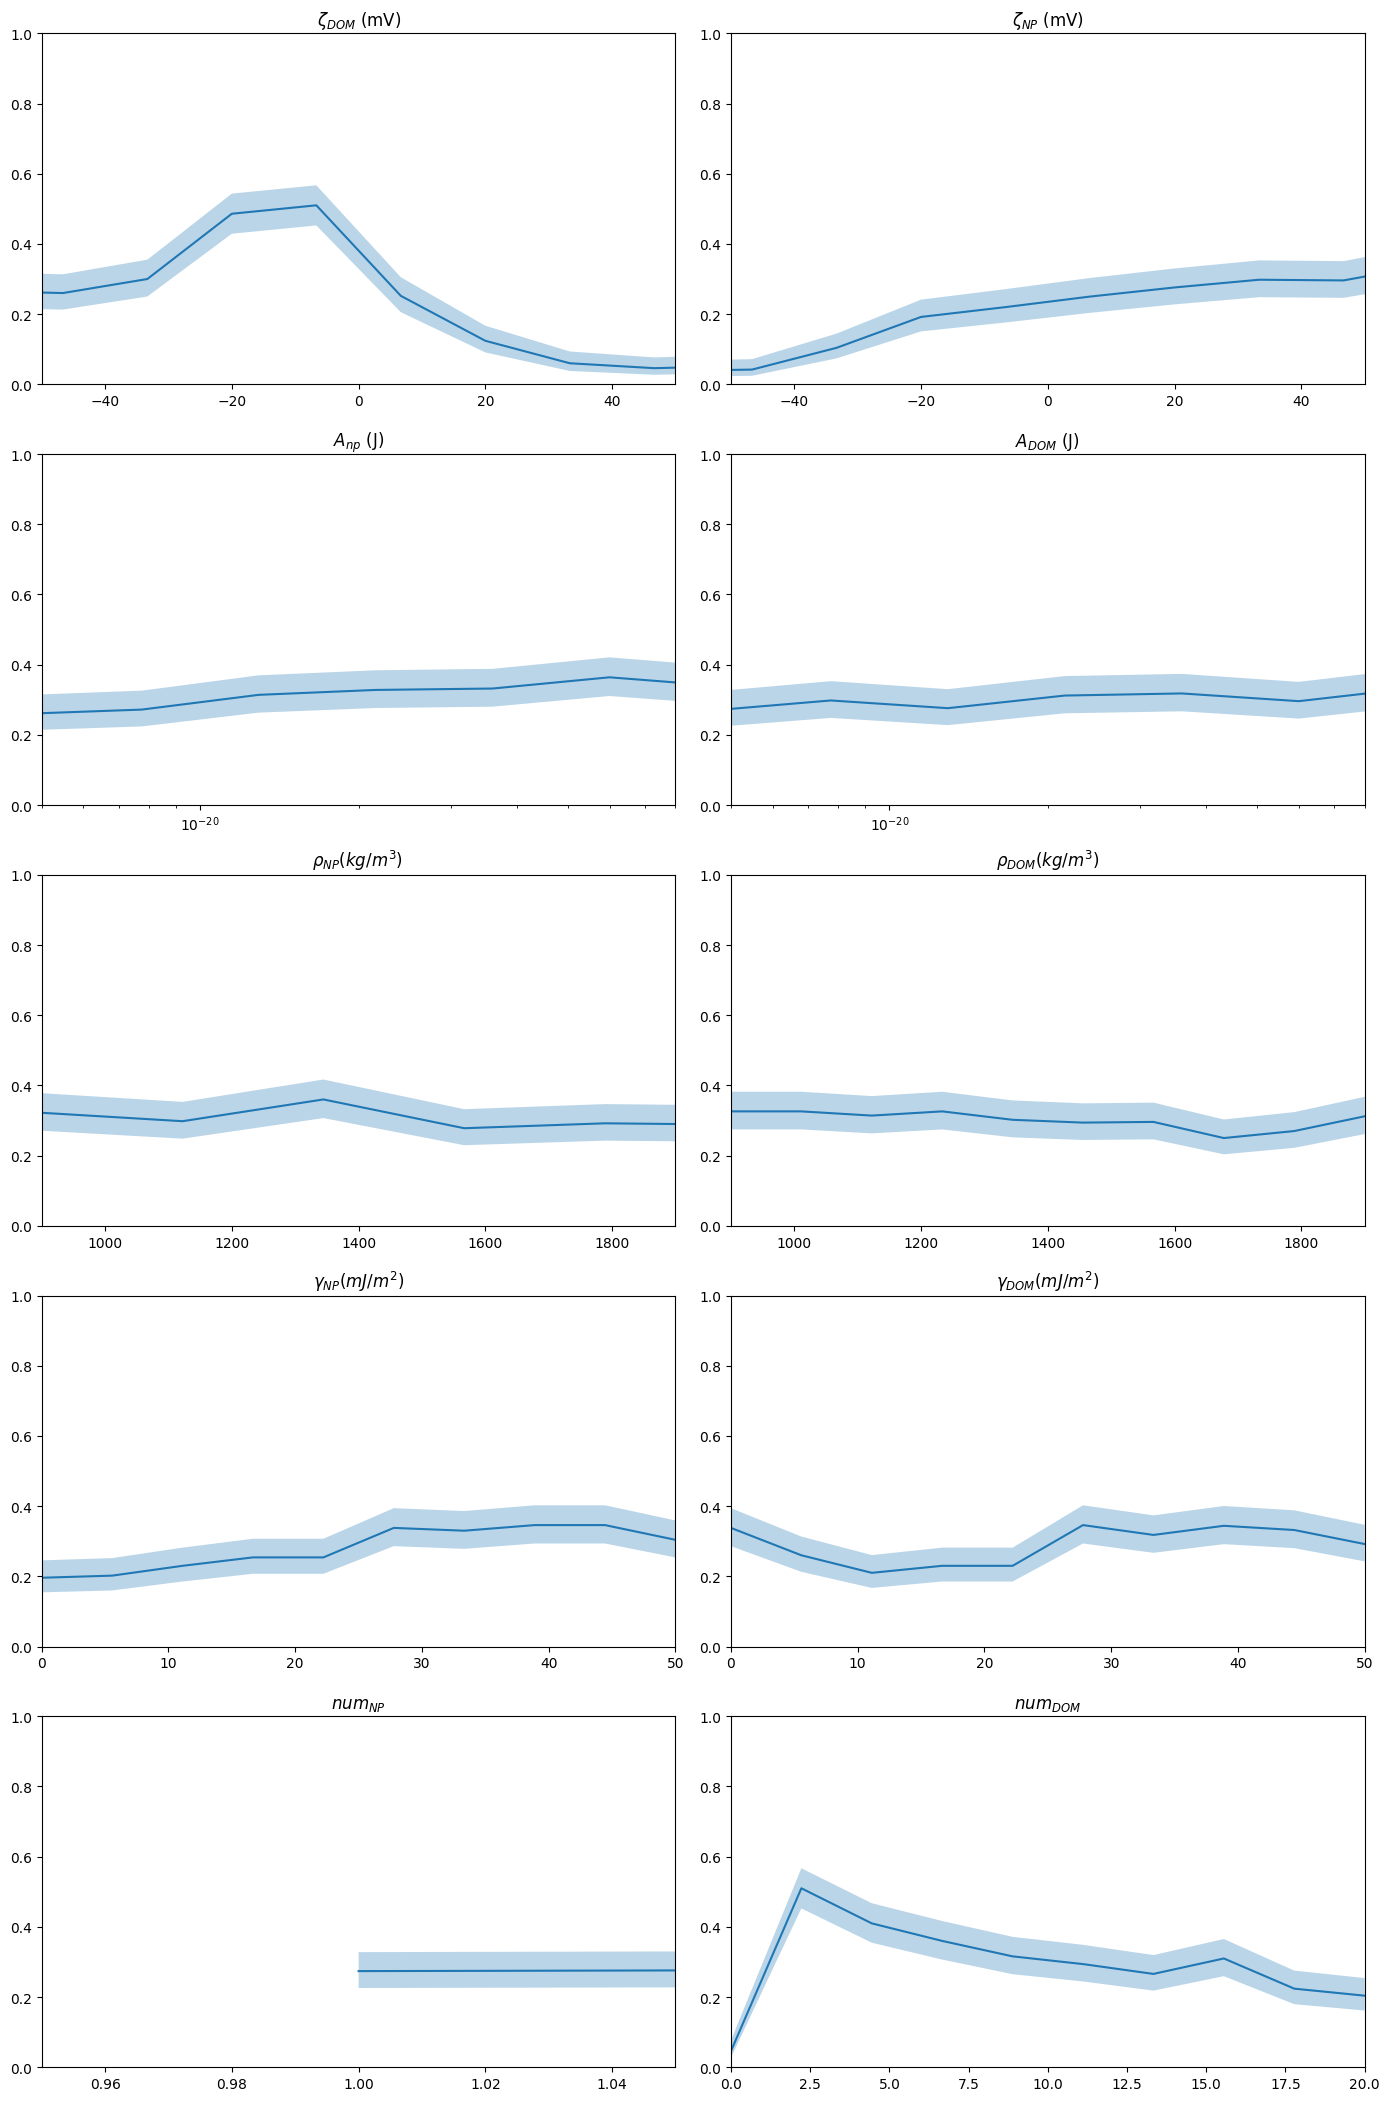

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
lower_lims = [-50,-50, 5e-21, 5e-21, 900, 900, 0.0,0.0,1,0]
upper_lims = [50,50, 8e-20, 8e-20, 1900, 1900, 50, 50,1,20]
names = [r'$\zeta_{DOM}$', r'$\zeta_{NP}$', r'$A_{np}$', r'$A_{DOM}$', r'$\rho_{NP}$', r'$\rho_{DOM}$',r'$\gamma_{NP}$', r'$\gamma_{DOM}$', r'$num_{NP}$', r'$num_{DOM}$']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
def plot_subplots_with_fill(data, conf_low, conf_high, names, values, lower_lims, upper_lims):
    num_subplots = len(data)

    # Check if the input contains exactly 17 arrays, each with 10 elements
    #if num_subplots != 17 or any(len(subarray) != 10 for subarray in data):
    #    raise ValueError("Input must be an array containing 17 arrays, each with 10 elements.")

    # Create a 4x5 grid for subplots
    fig, axes = plt.subplots(5, 2, figsize=(14, 22))
    #fig.suptitle('17 Subplots with 10 Elements Each and 25-75% Percentile Fill')

    # Flatten the 2D array of subplot axes to easily iterate over them
    axes = axes.flatten()

    for i, (subplot_data, subplot_low, subplot_high, name, value) in enumerate(zip(data, conf_low, conf_high, names, values)):
        # Plot the data on the current subplot
        axes[i].plot(value, subplot_data, label='Data')

        # Plot the 25-75% percentile fill area
        lower_bound = subplot_low
        print(subplot_data)
        #print(lower_bound)
        upper_bound = subplot_high
        axes[i].set_title(name)
        axes[i].fill_between(value, lower_bound, upper_bound, alpha=0.3, label='25-75% Percentile')
        axes[i].set_ylim(0.0, 1)
        axes[i].set_xlim(lower_lims[i], upper_lims[i])
        ax.set_ylabel(r"$\alpha$")
        ax.set_xlabel(name)
        if i==2 or i==3:
            axes[i].set_xscale('log')
        #axes[i].set_title(f'Subplot {i + 1}')
        #axes[i].legend()

    # Adjust layout to prevent overlapping titles
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()


# Example usage:
# Replace 'your_input_data' and 'your_input_std' with
plot_subplots_with_fill(pred_mat2, pred_mat2_low, pred_mat2_high, names, parameter_val, lower_lims, upper_lims)

In [ ]:
pred_mat3[0]

array([[0.042, 0.194, 0.534, 0.488, 0.436, 0.4  , 0.394, 0.372, 0.328,
        0.316, 0.266, 0.288, 0.24 , 0.252, 0.242],
       [0.032, 0.174, 0.478, 0.47 , 0.462, 0.376, 0.358, 0.378, 0.322,
        0.368, 0.26 , 0.282, 0.3  , 0.258, 0.248],
       [0.042, 0.072, 0.524, 0.492, 0.478, 0.4  , 0.414, 0.372, 0.324,
        0.324, 0.3  , 0.298, 0.264, 0.268, 0.242],
       [0.056, 0.05 , 0.38 , 0.674, 0.734, 0.698, 0.692, 0.636, 0.606,
        0.534, 0.486, 0.466, 0.406, 0.358, 0.288],
       [0.042, 0.024, 0.14 , 0.39 , 0.522, 0.582, 0.576, 0.54 , 0.588,
        0.578, 0.51 , 0.494, 0.446, 0.44 , 0.388],
       [0.036, 0.032, 0.082, 0.102, 0.146, 0.222, 0.216, 0.234, 0.258,
        0.27 , 0.252, 0.238, 0.216, 0.272, 0.254],
       [0.048, 0.026, 0.036, 0.028, 0.064, 0.074, 0.078, 0.068, 0.108,
        0.118, 0.124, 0.078, 0.102, 0.126, 0.152],
       [0.05 , 0.05 , 0.05 , 0.04 , 0.064, 0.046, 0.066, 0.058, 0.076,
        0.062, 0.06 , 0.068, 0.094, 0.064, 0.088],
       [0.048, 0.032, 0.

0
1
2
3
4
5
6
7
8
9
(60, 40)
(60, 40)
(60, 40)


<ipython-input-130-9d8c74ee61fe>:72: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-130-9d8c74ee61fe>:73: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-130-9d8c74ee61fe>:74: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


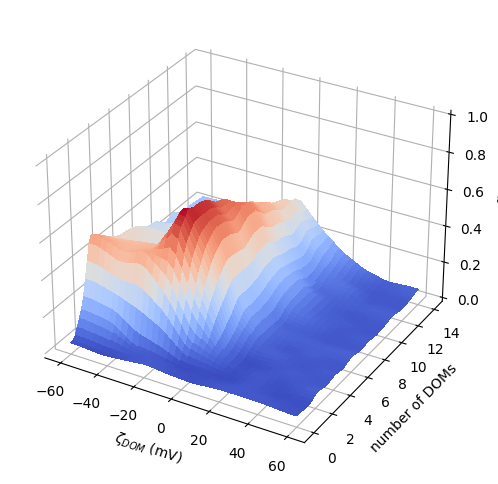

(60, 40)
(60, 40)
(60, 40)


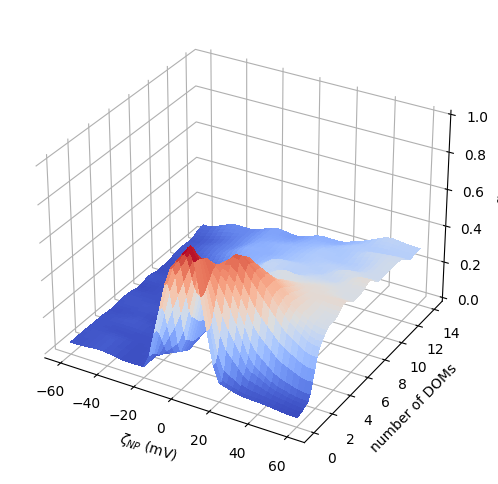

(60, 40)
(60, 40)
(60, 40)


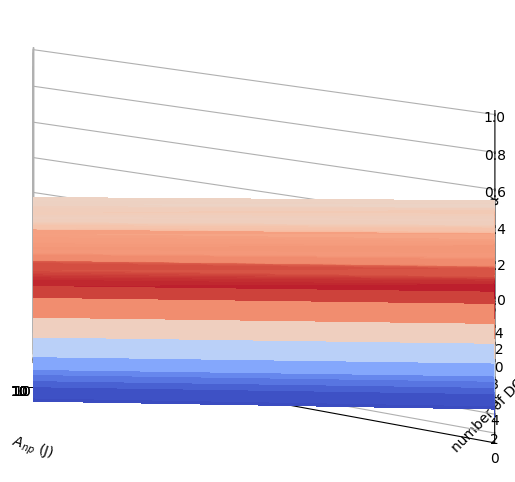

(60, 40)
(60, 40)
(60, 40)


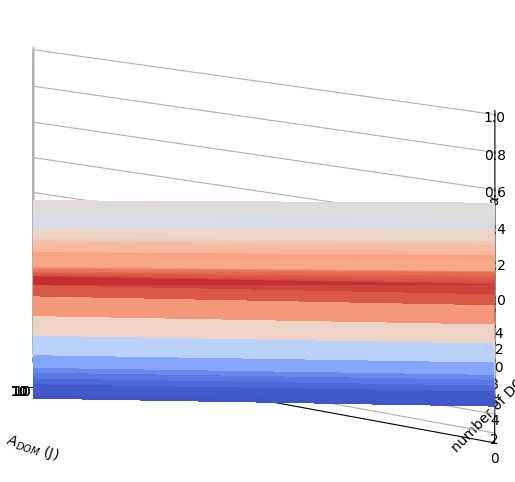

(60, 40)
(60, 40)
(60, 40)


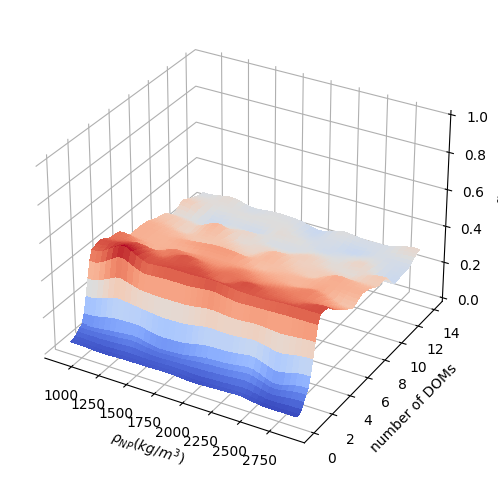

(60, 40)
(60, 40)
(60, 40)


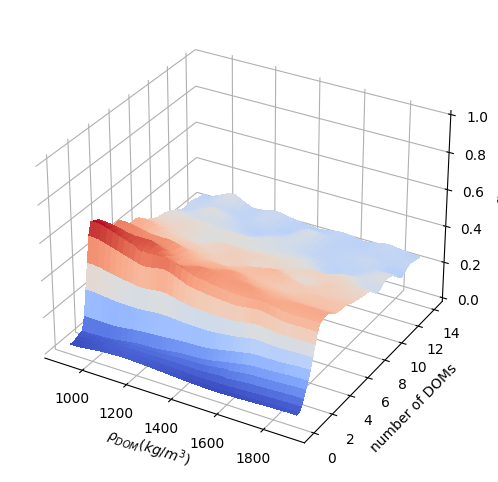

(60, 40)
(60, 40)
(60, 40)


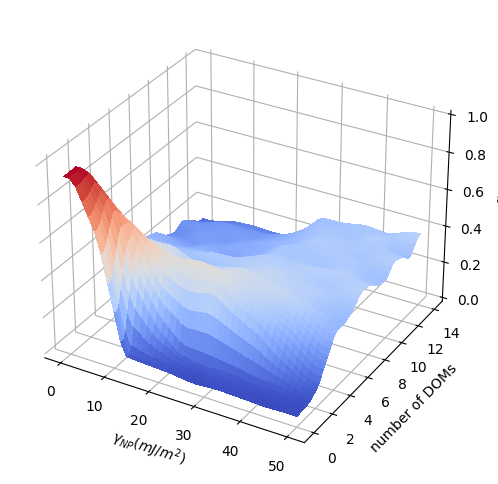

(60, 40)
(60, 40)
(60, 40)


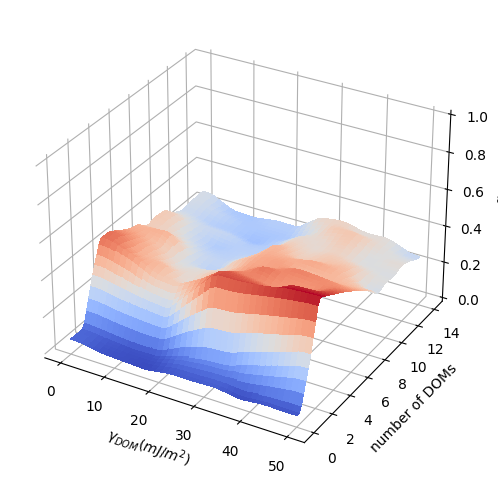

(60, 40)
(60, 40)
(60, 40)


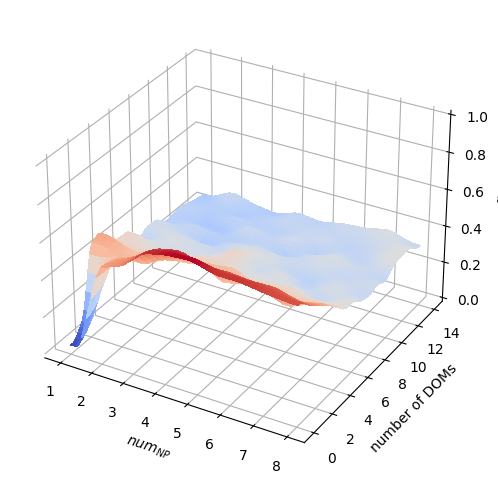

(60, 40)
(60, 40)
(60, 40)


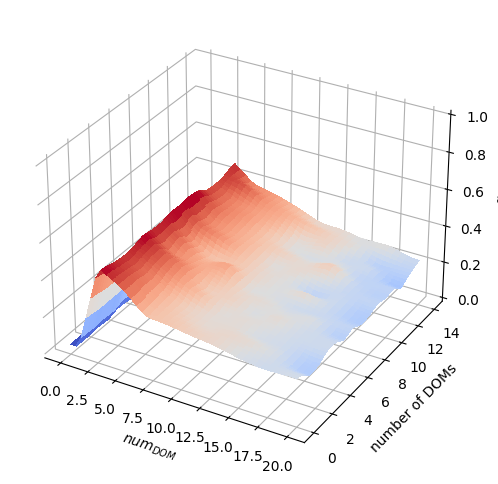

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import shutil
import zipfile
import cv2

parameter_val = np.zeros([10,40])
array_dom = np.linspace(-6.6289e-01,5.1692,10)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),40);
  for i in range(40):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     #for k in range(10):
     #X_play2[9] = array_dom[k];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     parameter_val[j,i] = paramv[0][j];

DOM_list = np.loadtxt('/content/DOM_list.txt')
DOM_list

pred_mat3 = np.zeros([17,len(DOM_list),10]);
pred_mat3_std = np.zeros([17,len(DOM_list),10]);
pred_mat3_low = np.zeros([17,len(DOM_list),10]);
pred_mat3_high = np.zeros([17,len(DOM_list),10]);
#parameter_val = np.zeros([17,10]);
for kj in range(len(DOM_list)):
  p1 = np.loadtxt(f'/content/sample_data/npnp_agg_st_DOM={DOM_list[kj]}/pred_mat3_npnp_agg_st_DOM={DOM_list[kj]}.txt');
  p1_low = np.loadtxt(f'/content/sample_data/npnp_agg_st_DOM={DOM_list[kj]}/pred_mat3_low_npnp_agg_st_DOM={DOM_list[kj]}.txt');
  p1_high = np.loadtxt(f'/content/sample_data/npnp_agg_st_DOM={DOM_list[kj]}/pred_mat3_high_npnp_agg_st_DOM={DOM_list[kj]}.txt');

  for i in range(17):
    for j in range(10):
     # for k in range(len(DOM_list)):
      pred_mat3[i,kj,j] = p1[i,j];
      pred_mat3_low[i,kj,j] = p1_low[i,j];
      pred_mat3_high[i,kj,j] = p1_high[i,j];


parameter_val[0,:] = parameter_val[0,:]*1000;
parameter_val[1,:] = parameter_val[1,:]*1000;
parameter_val[2,:] = np.exp(parameter_val[2,:]);
parameter_val[3,:] = np.exp(parameter_val[3,:]);
parameter_val[6,:] = parameter_val[6,:]*1000;
parameter_val[7,:] = parameter_val[7,:]*1000;

def plot_3d_subplots(data, data_low, data_high, names, names_raw, parameter_val,  lower_lims, upper_lims):
 output_folder = "/content/NPNPagg_st"
 if not os.path.exists(output_folder):
        os.makedirs(output_folder)

 for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a new figure for each subplot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        value2 = np.linspace(value[0],value[-1],40);
        # Create a meshgrid for the 10x10 array
        y, x = np.meshgrid(np.transpose(value), np.linspace(0,14,60));

        arr =  cv2.resize(array, (40, 60), interpolation=cv2.INTER_LINEAR)
        print(arr.shape)
        print(x.shape)
        print(y.shape)
        # Plot the 3D surface
        ax.plot_surface(y,x,(arr), cmap=cm.coolwarm, edgecolor='none',  antialiased=False, rcount=10000, ccount=10000)
        ax.set_zlim(0, 1)

        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_xlabel(name)
        ax.set_ylabel('number of DOMs')
        ax.set_zlabel(r'$\alpha$')
        #ax.set_xlim(value[0], value[39])
        #ax.set_xlim(lower_lims[i], upper_lims[i])
        if i==2 or i==3:
            ax.set_xscale('log')
        # Save each individual figure with extended bbox
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #pad_inches_x = -0.3  # Adjust the padding to the right
        #pad_inches_y = -0.6  # Adjust the padding down
        #extent.x0 += pad_inches_x
        #extent.y0 += -0.5
        #extent.x1 += 0.52
        #extent.y1 += 0
        file_path = os.path.join(output_folder, f'NPNPagg_{names_raw[i]}_st.png')
        fig.savefig(file_path)
        #fig.savefig(f'NPNPagg_{names_raw[i]}.png')

        # Close the figure to release resources
        plt.show()
        plt.close(fig)
 shutil.make_archive(output_folder, 'zip', output_folder)
    # Show the plot (optional)


# Example usage:
# Replace the following with your actual data


# Call the function
lower_lims = [-50,-50, 5e-21, 5e-21, 1050, 800, 0, 0,1,0]
upper_lims = [50,50, 8e-20, 8e-20, 1700, 2000, 50, 50,1,12]
#names = ['zp_dom', 'zp', 'A_np', 'A_dom', 'rho_np', 'rho_dom','g_np', 'g_dom', 'num_np', 'num_dom']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
names_raw = [r'zeta_DOM', r'zeta_NP', r'A_NP', r'A_DOM', r'rho_NP', r'rho_DOM',r'gamma_NP', r'gamma_DOM', r'num_NP', r'num_DOM']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, names_raw,parameter_val, lower_lims, upper_lims)


# 3d

In [ ]:
pred_mat = np.zeros([17,20]);
pred_mat3 = np.zeros([17,20,20]);
pred_mat3_std = np.zeros([17,20,20]);
pred_mat3_low = np.zeros([17,20,20]);
pred_mat3_high = np.zeros([17,20,20]);
parameter_val = np.zeros([17,20]);
X_play = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);
X_play = torch.tensor([-1.085, +1.01,
                       0, 0,
                       0, 0,
                        0, 0,
                       -0.2102,  -6.6289e-01]);
scaler.inverse_transform(X_play.reshape(1, -1))

arrayv = np.linspace(-2.2,2.2,20)
array_dom = np.linspace(-6.6289e-01,5.1692,20)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),20);
  for i in range(20):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     for k in range(20):
        X_play2[9] = array_dom[k];
        paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
        parameter_val[j,i] = paramv[0][j];
        #parameter_val[i]
        preds1 = predictive(X_play2)
         #y_pred1 = preds1['obs'].T.detach().numpy().mean(axis=1)
         #pred_mat[j,i] = y_pred1;
        pred_mat3[j,i,k] = (sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
        #pred_mat3_std[j,i,k] = np.std((preds1['obs']>0).detach().numpy())
        y_pred1 = (preds1['obs']>0).detach().numpy()*1;
        ci_low, ci_upp = proportion_confint(sum(y_pred1), len(y_pred1), alpha=0.01, method='wilson')
        pred_mat3_low[j,i,k] = ci_low;
        pred_mat3_high[j,i,k] = ci_upp;

0
1
2
3
4
5
6
7
8
9


In [ ]:
import numpy as np

# Assuming pred_mat3, pred_mat3_low, pred_mat3_high are your NumPy arrays

# Save pred_mat3
np.savetxt('pred_mat3_npnp_agg_st.txt', pred_mat3.flatten().reshape(pred_mat3.shape[0], -1))
np.savetxt('pred_mat3_low_npnp_agg_st.txt', pred_mat3_low.flatten().reshape(pred_mat3.shape[0], -1))
np.savetxt('pred_mat3_high_npnp_agg_st.txt', pred_mat3_high.flatten().reshape(pred_mat3.shape[0], -1))
np.savetxt('parameter_val_npnp_agg_st.txt', parameter_val)

0
1
2
3
4
5
6
7
8
9


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10, 20) and arg 2 with shape (20, 20).

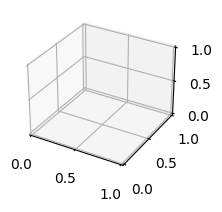

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


array_dom = np.linspace(-6.6289e-01,5.1692,10)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),10);
  for i in range(10):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     for k in range(10):
        X_play2[9] = array_dom[k];
        paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
        parameter_val[j,i] = paramv[0][j];


parameter_val[0,:] = parameter_val[0,:]*1000;
parameter_val[1,:] = parameter_val[1,:]*1000;
parameter_val[2,:] = np.exp(parameter_val[2,:]);
parameter_val[3,:] = np.exp(parameter_val[3,:]);
parameter_val[6,:] = parameter_val[6,:]*1000;
parameter_val[7,:] = parameter_val[7,:]*1000;

def plot_3d_subplots(data, data_low, data_high, names, names_raw, parameter_val):
    num_subplots = len(data)

    # Check if the input contains exactly 17 arrays, each with dimensions 10x10
    #if num_subplots != 17 or any(subarray.shape != (20, 20) for subarray in data):
    #    raise ValueError("Input must be an array containing 17 arrays, each with dimensions 10x10.")

    # Create a 4x5 grid for subplots
    fig = plt.figure(figsize=(15, 12))
    #fig.suptitle('1 Subplots with 3D Surface Plot of 10x10 Arrays')
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a 3D subplot
        ax = fig.add_subplot(4, 5, i + 1, projection='3d')

        # Create a meshgrid for the 10x10 array
        x, y = np.meshgrid(value, np.arange(10))

        #array_25=array[0:10]-array_std[0:10]*0.67
        #array_75=array[0:10]+array_std[0:10]*0.67
        # Plot the 3D surface
        ax.plot_surface(x, y, array, cmap='viridis', edgecolor='k')
        #surf2 = ax.plot_surface(x, y, array_low, cmap='gray', edgecolor='none', alpha=0.5, linewidth=0)
        #surf3 = ax.plot_surface(x, y, array_high, cmap='gray', edgecolor='none', alpha=0.5, linewidth=0)
        #ax.set_title(name)  # Set the title to the corresponding name
        ax.set_zlim(0, 1)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_xlabel(name)
        ax.set_ylabel('number of DOMs')
        ax.set_zlabel(r'$\alpha$')

        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #pad_inches = 0.4  # Adjust the padding as needed
        pad_inches_x = -0.3  # Adjust the padding to the right
        pad_inches_y = -0.6  # Adjust the padding down
        #print(extent)
        extent.x0 += pad_inches_x
        extent.y0 += -0.5
        extent.x1 += 0.52
        extent.y1 += 0

        #extent = extent.expanded(1 + pad_inches, 1 + pad_inches)
        fig.savefig(f'NPNPagg_{names_raw[i]}.png', bbox_inches=extent)
        #ax.savefig(f'subplot_{i + 1}.png')
        #if i==2 or i==3:
            #ax.set_xscale('log')
    # Adjust layout to prevent overlapping titles
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()

# Example usage:
# Replace 'your_3d_data' and 'your_names' with the actual 3D array and array of names
# 'your_3d_data' is the 3D array with dimensions 17x10x10, and 'your_names' is the array of names
your_3d_data = np.random.rand(17, 10, 10)
#your_names = ['Name1', 'Name2', 'Name3', 'Name4', 'Name5', 'Name6', 'Name7', 'Name8', 'Name9', 'Name10',
#              'Name11', 'Name12', 'Name13', 'Name14', 'Name15', 'Name16', 'Name17']
lower_lims = [-0.05,-0.05, 5e-21, 5e-21, 1050, 800, 0.001,0.001,1,0]
upper_lims = [0.05,0.05, 8e-20, 8e-20, 1700, 2000, 0.05,0.05,1,12]
#names = ['zp_dom', 'zp', 'A_np', 'A_dom', 'rho_np', 'rho_dom','g_np', 'g_dom', 'num_np', 'num_dom']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
names_raw = [r'zeta_DOM', r'zeta_NP', r'A_NP', r'A_DOM', r'rho_NP', r'rho_DOM',r'gamma_NP', r'gamma_DOM', r'num_NP', r'num_DOM']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, names_raw,parameter_val)


In [ ]:
parameter_val

array([[-6.00000002e+01, -5.36842129e+01, -4.73684206e+01,
        -4.10526333e+01, -3.47368434e+01, -2.84210536e+01,
        -2.21052638e+01, -1.57894740e+01, -9.47368542e+00,
        -3.15789560e+00,  3.15789406e+00,  9.47368341e+00,
         1.57894726e+01,  2.21052624e+01,  2.84210522e+01,
         3.47368420e+01,  4.10526294e+01,  4.73684192e+01,
         5.36842115e+01,  5.99999988e+01],
       [-6.00000019e+01, -5.36842106e+01, -4.73684240e+01,
        -4.10526327e+01, -3.47368437e+01, -2.84210548e+01,
        -2.21052635e+01, -1.57894745e+01, -9.47368555e+00,
        -3.15789571e+00,  3.15789383e+00,  9.47368367e+00,
         1.57894726e+01,  2.21052616e+01,  2.84210529e+01,
         3.47368418e+01,  4.10526308e+01,  4.73684221e+01,
         5.36842087e+01,  6.00000000e+01],
       [ 1.00000012e-21,  1.27427502e-21,  1.62377704e-21,
         2.06913828e-21,  2.63665091e-21,  3.35981882e-21,
         4.28133270e-21,  5.45559534e-21,  6.95192805e-21,
         8.85866831e-21,  1.1

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import shutil
import zipfile

parameter_val = np.zeros([17,20]);
array_dom = np.linspace(-6.6289e-01,5.1692,20)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),20);
  for i in range(20):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     for k in range(20):
        X_play2[9] = array_dom[k];
        paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
        parameter_val[j,i] = paramv[0][j];


parameter_val[0,:] = parameter_val[0,:]*1000;
parameter_val[1,:] = parameter_val[1,:]*1000;
parameter_val[2,:] = np.exp(parameter_val[2,:]);
parameter_val[3,:] = np.exp(parameter_val[3,:]);
parameter_val[6,:] = parameter_val[6,:]*1000;
parameter_val[7,:] = parameter_val[7,:]*1000;

def plot_3d_subplots(data, data_low, data_high, names, names_raw, parameter_val,  lower_lims, upper_lims):
 output_folder = "/kaggle/working/NPNPagg"
 if not os.path.exists(output_folder):
        os.makedirs(output_folder)

 for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a new figure for each subplot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Create a meshgrid for the 10x10 array
        x, y = np.meshgrid(value, np.linspace(0,14,20))
        print(value)
        # Plot the 3D surface
        ax.plot_surface(x, y, array, cmap=cm.coolwarm, edgecolor='none',  antialiased=False, rcount=2000, ccount=2000)
        ax.set_zlim(0, 1)

        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_xlabel(name)
        ax.set_ylabel('number of DOMs')
        ax.set_zlabel(r'$\alpha$')
        #ax.set_xlim(lower_lims[i], upper_lims[i])
        if i==2 or i==3:
            ax.set_xscale('log')
        # Save each individual figure with extended bbox
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #pad_inches_x = -0.3  # Adjust the padding to the right
        #pad_inches_y = -0.6  # Adjust the padding down
        #extent.x0 += pad_inches_x
        #extent.y0 += -0.5
        #extent.x1 += 0.52
        #extent.y1 += 0
        file_path = os.path.join(output_folder, f'NPNPagg_{names_raw[i]}.png')
        fig.savefig(file_path)
        #fig.savefig(f'NPNPagg_{names_raw[i]}.png')

        # Close the figure to release resources
        plt.show()
        plt.close(fig)
 shutil.make_archive(output_folder, 'zip', output_folder)
    # Show the plot (optional)


# Example usage:
# Replace the following with your actual data


# Call the function
lower_lims = [-50,-50, 5e-21, 5e-21, 1050, 800, 0, 0,1,0]
upper_lims = [50,50, 8e-20, 8e-20, 1700, 2000, 50, 50,1,12]
#names = ['zp_dom', 'zp', 'A_np', 'A_dom', 'rho_np', 'rho_dom','g_np', 'g_dom', 'num_np', 'num_dom']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
names_raw = [r'zeta_DOM', r'zeta_NP', r'A_NP', r'A_DOM', r'rho_NP', r'rho_DOM',r'gamma_NP', r'gamma_DOM', r'num_NP', r'num_DOM']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, names_raw,parameter_val, lower_lims, upper_lims)


In [ ]:
pred_mat3[6]

array([[0.024     , 0.018     , 0.008     , 0.68400002, 0.87      ,
        0.88      , 0.80400002, 0.66799998, 0.34400001, 0.138     ],
       [0.016     , 0.03      , 0.016     , 0.19599999, 0.77200001,
        0.83200002, 0.71799999, 0.40400001, 0.12800001, 0.072     ],
       [0.022     , 0.03      , 0.014     , 0.03      , 0.54400003,
        0.65600002, 0.43399999, 0.15800001, 0.108     , 0.08      ],
       [0.04      , 0.018     , 0.03      , 0.026     , 0.39399999,
        0.51800001, 0.23199999, 0.162     , 0.132     , 0.098     ],
       [0.032     , 0.024     , 0.028     , 0.014     , 0.352     ,
        0.26199999, 0.24600001, 0.19      , 0.22      , 0.184     ],
       [0.018     , 0.026     , 0.018     , 0.026     , 0.34400001,
        0.28400001, 0.27599999, 0.324     , 0.41600001, 0.47799999],
       [0.012     , 0.036     , 0.018     , 0.022     , 0.30399999,
        0.31999999, 0.338     , 0.472     , 0.574     , 0.59399998],
       [0.018     , 0.022     , 0.02     

## 3d

In [ ]:
pred_mat = np.zeros([17,20]);
pred_mat3 = np.zeros([17,20,10]);
pred_mat3_std = np.zeros([17,20,10]);
parameter_val = np.zeros([17, 20]);
X_play = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);

arrayv = np.linspace(-2,2,10)
for j in range(17):
  print(j);
  for i in range(20):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     for k in range(10):
        X_play2[14] = arrayv[k];
        paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
        parameter_val[j,i] = paramv[0][j];
        parameter_val[i]
        preds1 = predictive(X_play2)
         #y_pred1 = preds1['obs'].T.detach().numpy().mean(axis=1)
         #pred_mat[j,i] = y_pred1;
        pred_mat3[j,i,k] = (sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
        pred_mat3_std[j,i,k] = np.std((preds1['obs']>0).detach().numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
pred_mat3[0][0:10]

array([[0.108     , 0.122     , 0.13      , 0.122     , 0.13600001,
        0.116     , 0.096     , 0.076     , 0.098     , 0.096     ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.122     , 0.092     , 0.096     , 0.148     , 0.13      ,
        0.14399999, 0.104     , 0.088     , 0.064     , 0.068     ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.086     , 0.114     , 0.108     , 0.1       , 0.104     ,
        0.098     , 0.098     , 0.084     , 0.08      , 0.1       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.108     , 0.132     , 0.132     , 0.114     , 0.106     ,
        0.098     , 0.066     , 0.082     , 0.108     , 0.088     ,
        0.        , 0.        , 0.        , 0

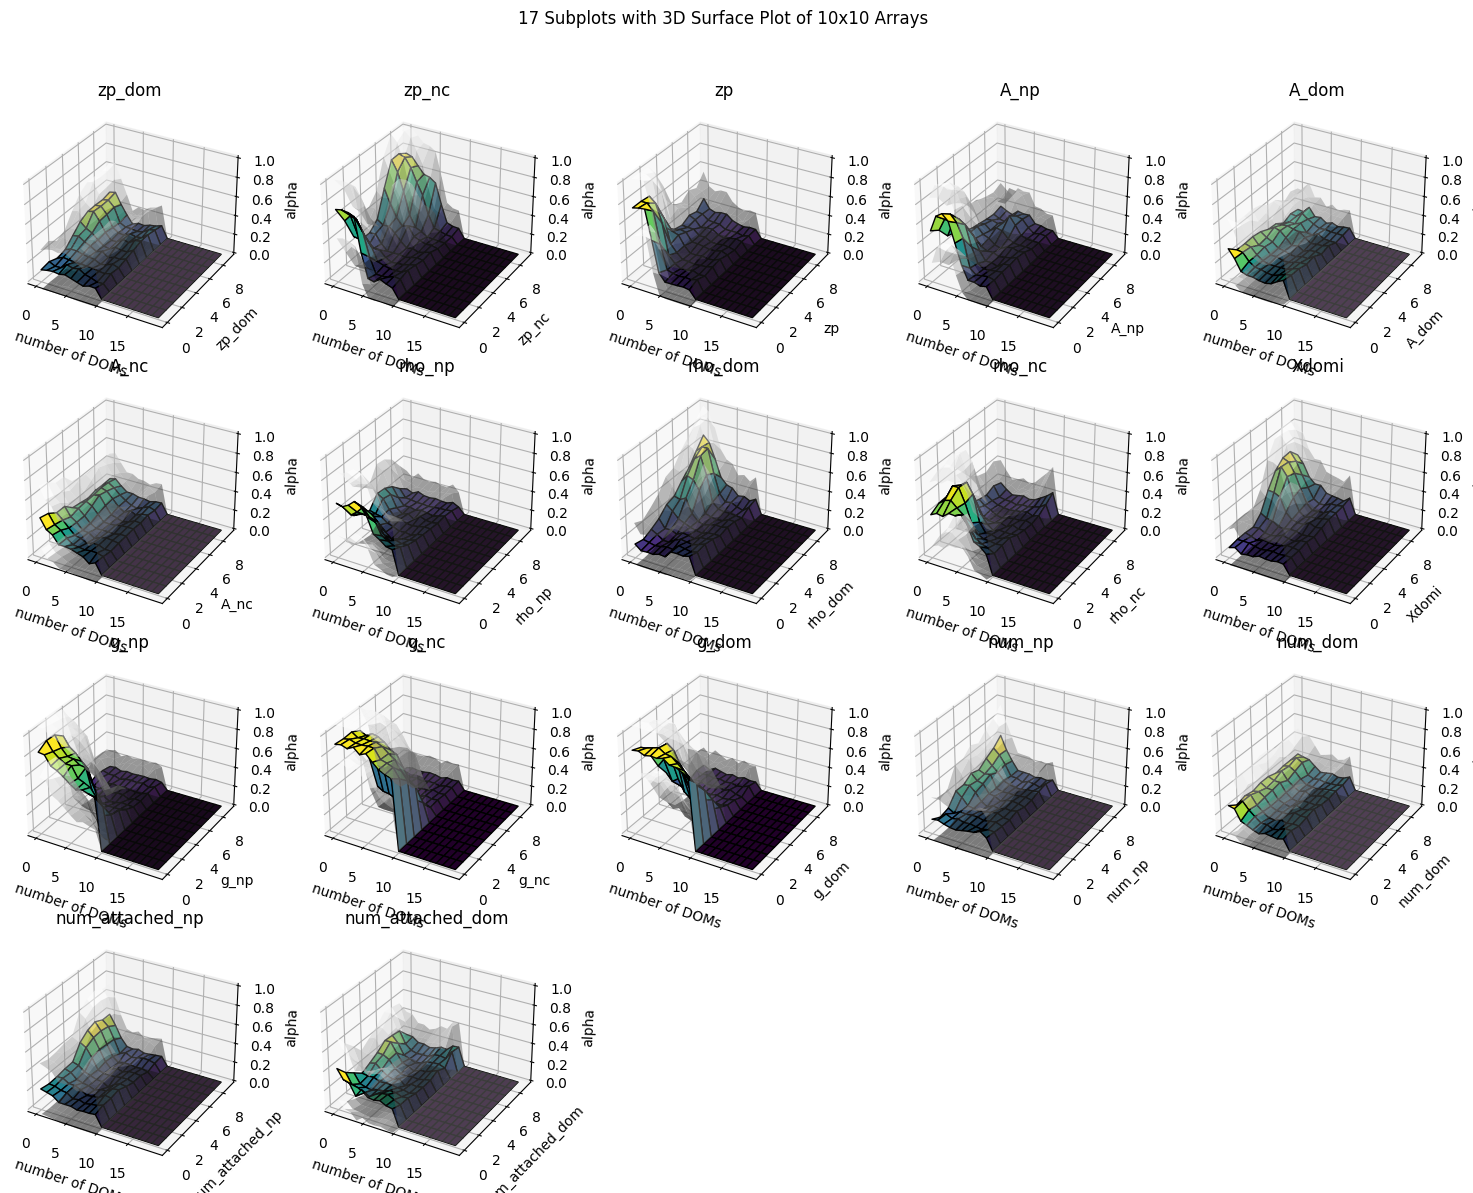

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_subplots(data, data_std, names):
    num_subplots = len(data)

    # Check if the input contains exactly 17 arrays, each with dimensions 10x10
    if num_subplots != 17 or any(subarray.shape != (20, 20) for subarray in data):
        raise ValueError("Input must be an array containing 17 arrays, each with dimensions 10x10.")

    # Create a 4x5 grid for subplots
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle('17 Subplots with 3D Surface Plot of 10x10 Arrays')

    for i, (array, array_std, name) in enumerate(zip(data, data_std, names)):
        # Create a 3D subplot
        ax = fig.add_subplot(4, 5, i + 1, projection='3d')

        # Create a meshgrid for the 10x10 array
        x, y = np.meshgrid(np.arange(20), np.arange(10))

        array_25=array[0:10]-array_std[0:10]*0.67
        array_75=array[0:10]+array_std[0:10]*0.67
        # Plot the 3D surface
        ax.plot_surface(x, y, array[0:10], cmap='viridis', edgecolor='k')
        surf2 = ax.plot_surface(x, y, array_25, cmap='gray', edgecolor='none', alpha=0.5, linewidth=0)
        surf3 = ax.plot_surface(x, y, array_75, cmap='gray', edgecolor='none', alpha=0.5, linewidth=0)
        ax.set_title(name)  # Set the title to the corresponding name
        ax.set_zlim(0, 1)

        ax.set_ylabel(name)
        ax.set_xlabel('number of DOMs')
        ax.set_zlabel('alpha')
    # Adjust layout to prevent overlapping titles
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()

# Example usage:
# Replace 'your_3d_data' and 'your_names' with the actual 3D array and array of names
# 'your_3d_data' is the 3D array with dimensions 17x10x10, and 'your_names' is the array of names
your_3d_data = np.random.rand(17, 10, 10)
your_names = ['Name1', 'Name2', 'Name3', 'Name4', 'Name5', 'Name6', 'Name7', 'Name8', 'Name9', 'Name10',
              'Name11', 'Name12', 'Name13', 'Name14', 'Name15', 'Name16', 'Name17']
lower_lims = [-0.05,-0.05, -0.05, 1e-21, 1e-21, 1e-21, 1050, 800, 2000,0, 0.001,0.001,0.001,0,0,0,0]
upper_lims = [0.05,0.05, 0.05, 1e-19, 1e-19, 1e-19, 2800, 1700, 3000,2000, 0.05,0.05,0.05,2,12,5,12]
names = ['zp_dom','zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc', 'Xdomi', 'g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np', 'num_attached_dom']
plot_3d_subplots(pred_mat3, pred_mat3_std, names)


In [ ]:
preds1 = predictive(X_play)
y_pred1 = preds1['obs'].T.detach().numpy().mean(axis=1)
y_pred1

array([0.833625], dtype=float32)

In [ ]:
preds = predictive(X_v)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

In [ ]:
y_test.shape

In [ ]:
!pip install shap

In [ ]:
import shap
explainer = shap.Explainer(model, guide, device="cuda" if torch.cuda.is_available() else "cpu")

# Create a dummy dataset for explanation
num_samples = 100
dummy_data = torch.randn(num_samples, 27)

# Compute SHAP values for the dummy data
shap_values = explainer.shap_values(dummy_data)

# Plot summary plot
shap.summary_plot(shap_values, dummy_data, feature_names=names;#[f"Feature {i}" for i in range(input_size)])

SyntaxError: invalid syntax (<ipython-input-9-28812bbb81ea>, line 12)

In [ ]:
print((model_predict(X_train.detach().numpy())))
print((X_train.T.detach().numpy()).dtype)

In [ ]:
len(names)

15

ExactExplainer explainer: 51it [2:07:05, 152.51s/it]


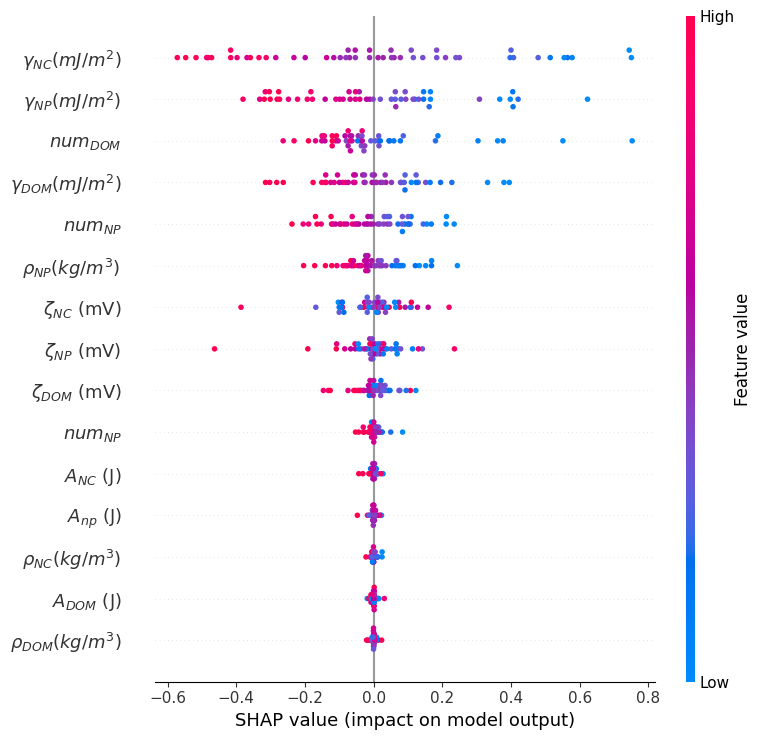

In [ ]:
#explainer = shap.Explainer(model, X_train)
import shap
from shap import ExactExplainer
num_samples = 50
import shap
def model_predict(X_test):
    X_test1 = torch.Tensor(X_test).float()
    predictive = Predictive(model, guide=guide, num_samples=500)
    #x_test = torch.linspace(-0.5, 1, 3000)
    pred = predictive(X_test1)
    val = torch.Tensor(pred['obs'].detach().numpy().mean(axis=0))
    #val.dtype = torch.float64;
    return val


# Create a KernelExplainer
dummy_data = torch.randn(num_samples, 15)
explainer = ExactExplainer(model_predict, dummy_data.detach().numpy())

# Compute SHAP values
shap_values = explainer(dummy_data.detach().numpy())
#

# Compute SHAP values for the dummy data
#shap_values = explainer.shap_values(X_train)
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NC}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$A_{NC}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\rho_{NC} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{NC} (mJ/m^{2})$',r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$', r'$num_{NP}$']
names_raw = [r'zeta_DOM', r'zeta_NC', r'zeta_NP', r'A_NP', r'A_DOM',  r'A_NC',r'rho_NP', r'rho_DOM', r'rho_NC',r'gamma_NP', r'gamma_NC', r'gamma_DOM', r'num_NP', r'num_DOM', r'num_NP']
# Plot summary plot
shap.summary_plot(shap_values, dummy_data, feature_names=[feature for feature in names])

In [ ]:
shap.summary_plot(shap_values, dummy_data, feature_names=[f"Feature {i}" for i in range(27)])

In [ ]:
!apt install octave


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aglfn default-jre-headless epstool fonts-droid-fallback fonts-freefont-otf fonts-noto-mono
  fonts-urw-base35 ghostscript gnuplot-data gnuplot-qt gsfonts imagemagick-6-common info
  install-info libamd2 libauthen-sasl-perl libbtf1 libcamd2 libccolamd2 libcholmod3 libclone-perl
  libcolamd2 libcombblas1.16.0 libcxsparse3 libdata-dump-perl libemf1 libencode-locale-perl
  libevdev2 libfftw3-double3 libfftw3-long3 libfftw3-mpi3 libfftw3-single3 libfile-listing-perl
  libfltk-gl1.3 libfltk1.3 libfont-afm-perl libglpk40 libglu1-mesa libgraphicsmagick++-q16-12
  libgraphicsmagick-q16-3 libgs9 libgs9-common libgudev-1.0-0 libhdf5-openmpi-103-1
  libhtml-form-perl libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl libhtml-tree-perl
  libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl

In [ ]:
!pip install oct2py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 768.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00


In [ ]:
from oct2py import octave as oct
oct.eval("cd /content/matlab/")
oct.eval("phase_plot_C10_I_var_Xdom")
#!cd /content/matlab/ & octave -W /content/matlab/phase_plot_C10_I_var_Xdom.m

octave not found, please see README


ImportError: cannot import name 'octave' from 'oct2py' (/usr/local/lib/python3.10/dist-packages/oct2py/__init__.py)

In [ ]:
X_play = torch.tensor([-1.085, -1.085, -1.01, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0.09,  -2, 0.09]);
X_play = torch.tensor([-1.085, -1.085, +1.01,
                       0, 0, 0,
                       0, 0, 0,
                       0, 0, 0,
                       -0.3828,  -2,  -0.7722]);
X_play = torch.tensor(np.median(X_train,0));   X_play[13] = min(X_train[:,13]); X_play[0] = 4/6*min(X_train[:,0]);  X_play[1] = 4/6*min(X_train[:,1]); X_play[2] = 0*max(X_train[:,2]);
X_play[14] = min(X_train[:,14]);
#X_play[9]= max(X_train[9]);# X_play[10]= min(X_train[10]); X_play[11]= min(X_train[11])
scaler.inverse_transform(X_play.reshape(1, -1))
paramv0 = scaler.inverse_transform(X_play.reshape(1, -1))
print(names)
print(paramv0)

['zp_dom', 'zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc', 'g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np']
[[-4.00522591e-02 -4.00149514e-02  1.56208407e-04  1.06081803e-20
   9.42668481e-21  1.06081797e-20  1.92564100e+03  1.41282100e+03
   2.48717900e+03  2.56410300e-02  2.56410300e-02  2.43589700e-02
   9.99999997e-01  2.05892683e-07  7.40985429e-08]]


In [ ]:
from statsmodels.stats.proportion import proportion_confint
pred_mat = np.zeros([17,10]);
pred_mat2 = np.zeros([17,10]);
pred_mat2_std = np.zeros([17,10]);
pred_mat2_low = np.zeros([17,10]);
pred_mat2_high = np.zeros([17,10]);
parameter_val = np.zeros([17,10]);
#X_play = torch.tensor([-1.085, -1.085, 1.01, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);
#X_play = torch.tensor([-1.085, -1.085, +1.01, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0,  -1,  0]);
#X_play = torch.tensor([-1.085, -1.085, 0.1, 0, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0.0,  -0.663]);
arrayv = np.linspace(min(X_train[:,13]),2*max(X_train[:,13]),17)

X_play2 = X_play.clone();
preds1 = predictive(X_play2)
y_pred1 = (preds1['obs']>0).detach().numpy()*1;
#pred_mat[j,i] = y_pred1;
pred_bare = np.mean(y_pred1);
i=0;
for j in range(17):
     print(j);
     #for i in range(10):
     X_play2 = X_play.clone();
     X_play2[13] = arrayv[j];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     preds1 = predictive(X_play2)
     y_pred1 = (preds1['obs']>0).detach().numpy()*1;
     #pred_mat[j,i] = y_pred1;
     pred_mat2[j,i] = np.mean(y_pred1);#(sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
     ci_low, ci_upp = proportion_confint(sum(y_pred1), len(y_pred1), alpha=0.01, method='wilson')
     pred_mat2_low[j,i] = ci_low;
     pred_mat2_high[j,i] = ci_upp;
     #pred_mat2_std[j,i] = np.std((preds1['obs']>0).detach().numpy())
     parameter_val[j,i] = paramv[0][13];


#import os
#import shutil

#output_folder = f"/content/sample_data/npnc_agg_st_DOM={X_play[13]}"
#if not os.path.exists(output_folder):
#        os.makedirs(output_folder)
#np.savetxt(f'{output_folder}/pred_mat3_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2)
#np.savetxt(f'{output_folder}/pred_mat3_low_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_low)
#np.savetxt(f'{output_folder}/pred_mat3_high_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_high)
#np.savetxt(f'{output_folder}/parameter_val_npnc_agg_st_DOM={X_play[13]}.txt', parameter_val)
#shutil.make_archive(output_folder, 'zip', output_folder)

0


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


1


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


2


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


3


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


4


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


5


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


6


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


7


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


8


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


9


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


10


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


11


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


12


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


13


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


14


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


15


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


16


<ipython-input-60-1cb75a94eab9>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_low[j,i] = ci_low;
<ipython-input-60-1cb75a94eab9>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_mat2_high[j,i] = ci_upp;


In [ ]:
max(X_train[:,13])

tensor(2.2182)

In [ ]:
parameter_val[:,0]

array([2.05892683e-07, 1.24999998e+00, 2.50000009e+00, 3.75000020e+00,
       5.00000015e+00, 6.25000009e+00, 7.50000012e+00, 8.75000015e+00,
       1.00000001e+01, 1.12500002e+01, 1.25000000e+01, 1.37499998e+01,
       1.50000002e+01, 1.62500000e+01, 1.74999998e+01, 1.87500002e+01,
       2.00000000e+01])

In [ ]:
pred_bare

0.828

[0.406      0.39777558 0.38955115 0.38132673 0.37310231 0.36487788
 0.35665346 0.34842903 0.34020461 0.33198019 0.32375576 0.31553134
 0.30730692 0.2990825  0.29085807 0.28263365 0.27440922]


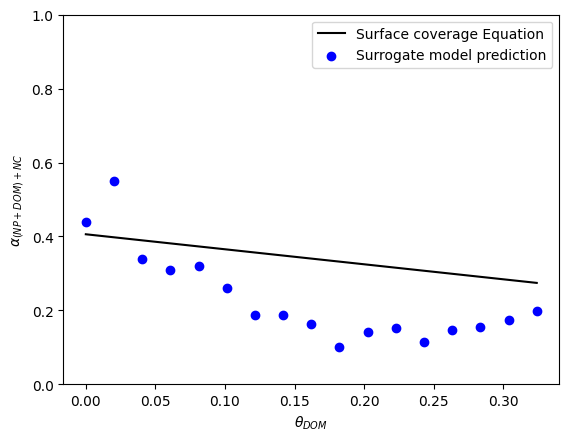

In [ ]:

theta = (parameter_val[:,0]/100)
predicted_alpha = (1-(parameter_val[:,0]/100))*pred_bare
print(predicted_alpha)
plt.plot(theta, predicted_alpha, label="Surface coverage Equation",color='k')
plt.scatter(theta,pred_mat2[:,0], label="Surrogate model prediction",color='b')
plt.ylim([0,1])
plt.ylabel(r"$\alpha_{(NP+DOM)+NC}$")
plt.xlabel(r"$\theta_{DOM}$")
plt.legend()

In [ ]:
pred_mat2[0:10,0]

array([0.828, 0.808, 0.82 , 0.784, 0.768, 0.68 , 0.542, 0.428, 0.292,
       0.194])